# This file is for SSA-CNN model

In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import IPython
import IPython.display
import matplotlib.pyplot as plt
import sys

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

## Read in my python class
from Window_Generator_package import Window_Generator

2023-08-01 04:17:03.235187: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-01 04:17:04.479858: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
train_path = './Data/Parameter_tuning_0.9997/63/Train/'
test_path = './Data/Parameter_tuning_0.9997/63/Test/'
full_path = './Data/Grouped/'

# stock_example = pd.read_csv(path + 'Data/Grouped/Consumer and Service Sectors/ALL.AX.csv')
def read_stock(path, file_name):
    stock = pd.read_csv(path + file_name, header = [0])
    stock_index = pd.to_datetime(stock['Date'])
    stock.index = stock_index
    stock = stock.drop('Date', axis = 1)
    return stock
group = ['Consumer and Service Sectors', 'Financial, Healthcare, Technology, and Utilities Sectors', 'Industrial and Infrastructure Sectors']
index = [0, 1, 2]
def read_all(the_path):
    All_df = []
    files = [f for f in os.listdir(the_path) if f.endswith('.csv')]

    for name in files:
        stock = read_stock(the_path + '/', name)
        All_df.append(stock)
    return All_df, files
train_All_df_0, train_files = read_all(train_path + group[index[0]])
test_All_df_0, test_files = read_all(test_path + group[index[0]])
full_All_df_0, full_files = read_all(full_path + group[index[0]])
example_train = train_All_df_0[0]
example_test = test_All_df_0[0]
example_actual = full_All_df_0[0][5:]

In [3]:
train_series_1 = example_train.iloc[:, 0]
test_series_1 = example_test.iloc[:, 0]

In [4]:
MAX_EPOCHS = 30

def compile_and_fit(model, X_train, Y_train, patience=5):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(X_train, Y_train, epochs=MAX_EPOCHS, verbose = 0)
  return history

In [5]:
def cnn_model(window_length):
  cnn = Sequential()
  cnn.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(5, 1), padding = 'same'))
  cnn.add(Conv1D(filters=64, kernel_size=window_length, activation='relu', input_shape=(5, 1)))
  cnn.add(Dense(64, activation='relu'))
  cnn.add(Dense(1, activation = 'linear'))
  return cnn

cnn = cnn_model(window_length = 5)

2023-08-01 04:17:08.002315: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-01 04:17:08.171991: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-01 04:17:08.172419: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-01 04:17:08.174317: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-01 04:17:08.174624: I tensorflow/compile

In [6]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 5, 64)             256       
                                                                 
 conv1d_1 (Conv1D)           (None, 1, 64)             20544     
                                                                 
 dense (Dense)               (None, 1, 64)             4160      
                                                                 
 dense_1 (Dense)             (None, 1, 1)              65        
                                                                 
Total params: 25,025
Trainable params: 25,025
Non-trainable params: 0
_________________________________________________________________


In [16]:
tf.keras.utils.plot_model(cnn)  

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [7]:
def obtain_prediction(X_train, Y_train, X_test, Y_test, window_length = 5):
  # The input train and test are all 3D list
  predicted_train_list = []
  predicted_test_list = []
  train_MAE_list = []
  test_MAE_list = []
  for i in range(5):
    cnn = cnn_model(window_length)
    history = compile_and_fit(cnn, X_train = X_train, Y_train = Y_train)
    # IPython.display.clear_output()
    train_performance = cnn.evaluate(X_train, Y_train)[1]
    test_performance = cnn.evaluate(X_test, Y_test)[1]
    # print('Train:', str(train_performance))
    # print('Test:', str(test_performance))
    Y_predict_train = cnn.predict(X_train)
    Y_predict_train = Y_predict_train.reshape(len(Y_predict_train))
    predicted_train_list.append(Y_predict_train)

    Y_predict_test = cnn.predict(X_test)
    Y_predict_test = Y_predict_test.reshape(len(Y_predict_test))
    predicted_test_list.append(Y_predict_test)

    train_MAE_list.append(train_performance)
    test_MAE_list.append(test_performance)

  train_MAE = np.mean(train_MAE_list)
  test_MAE = np.mean(test_MAE_list)

  predicted_train_list = np.array(predicted_train_list)
  predicted_train_list = np.mean(predicted_train_list, axis = 0)
  predicted_test_list = np.array(predicted_test_list)
  predicted_test_list = np.mean(predicted_test_list, axis = 0)

  return predicted_train_list, predicted_test_list, train_MAE, test_MAE

In [8]:
# Get result of 1 train and test series
def obtain_ONE_series(train_series, test_series, window_length = 5, show = None):

  # Data Preparation
  w = Window_Generator(train_series = train_series, test_series = test_series)
  _, _, train_mean, train_std, test_mean, test_std = w.standardization(show=True)
  _, _, _, _ = w.window_generation(show = True)
  X_train, X_test, Y_train, Y_test = w.data_getter()
  train_denormalized = w.denormalize_train()
  test_denormalized = w.denormalize_test()

  # Training and Prediction
  predicted_train_list, predicted_test_list, train_MAE, test_MAE = obtain_prediction(X_train, Y_train, X_test, Y_test, window_length = window_length)
  print('Train_MAE:', train_MAE)
  print('Test_MAE:', test_MAE)

  # Prediction Generation (Are train_set)

  train_index = w.train_index[w.window_length:]
  test_index = w.test_index

  Y_predict_train = pd.Series(predicted_train_list, index = train_index)
  Y_predict_train = Y_predict_train * train_std[w.window_length:] + train_mean[w.window_length:]
  Y_actual_train = Y_train.reshape(len(Y_train)) * train_std[w.window_length:] + train_mean[w.window_length:]
  Y_predict_train = pd.DataFrame(Y_predict_train, index = train_index)
  Y_actual_train = pd.DataFrame(Y_actual_train, index = train_index)

  Y_predict_test = pd.Series(predicted_test_list, index = test_index)
  Y_predict_test = Y_predict_test * test_std + test_mean
  Y_actual_test = Y_test.reshape(len(Y_test)) * test_std + test_mean
  Y_predict_test = pd.DataFrame(Y_predict_test, index = test_index)
  Y_actual_test = pd.DataFrame(Y_actual_test, index = test_index)

  if (show != None):
    plt.plot(Y_actual_train, label = 'Train Actual')
    plt.plot(Y_predict_train, label = 'Train predict')
    plt.plot(Y_actual_test, label = 'Test Actual')
    plt.plot(Y_predict_test, label = 'Test predict')
    plt.legend()
    plt.show()

  return Y_actual_train, Y_predict_train, Y_actual_test, Y_predict_test

In [9]:
def obtain_ONE_stock(train, test, show = None):
    length = len(train.columns)
    actual_train = []
    predict_train = []
    actual_test = []
    predict_test = []
    for i in range(length):
        train_series = train.iloc[:, i]
        test_series = test.iloc[:, i]
        Series_actual_train, Series_predict_train, Series_actual_test, Series_predict_test = obtain_ONE_series(train_series, test_series, window_length = 5, show = show)
        actual_train.append(Series_actual_train)
        predict_train.append(Series_predict_train)
        actual_test.append(Series_actual_test)
        predict_test.append(Series_predict_test)

    final_actual_train = pd.concat(actual_train)
    final_actual_train = final_actual_train.groupby(final_actual_train.index).sum()

    final_predict_train = pd.concat(predict_train)
    final_predict_train = final_predict_train.groupby(final_predict_train.index).sum()

    final_actual_test = pd.concat(actual_test)
    final_actual_test = final_actual_test.groupby(final_actual_test.index).sum()

    final_predict_test = pd.concat(predict_test)
    final_predict_test = final_predict_test.groupby(final_predict_test.index).sum()
    if (show != None):
        plt.plot(final_actual_train, label = 'Train Actual')
        plt.plot(final_predict_train, label = 'Train predict')
        plt.plot(final_actual_test, label = 'Test Actual')
        plt.plot(final_predict_test, label = 'Test predict')
        plt.legend()
        plt.show()

    return final_actual_train, final_predict_train, final_actual_test, final_predict_test

In [10]:
final_actual_train, final_predict_train, final_actual_test, final_predict_test = obtain_ONE_stock(example_train, example_test, show = True)

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)


KeyboardInterrupt: 

In [ ]:
Y_result = pd.concat([pd.concat([final_actual_train, final_predict_train], axis = 1), pd.concat([final_actual_test, final_predict_test], axis = 1)], axis = 0)
Y_result.columns = ['Smoothed_Actual', 'Predict']
Y_result = pd.concat([example_actual, Y_result], axis = 1)

## Here is the full combination:

In [ ]:
store_path = './Data/Parameter_tuning_0.9997/63_Prediction/SSA-CNN/'
def obtain_all(the_index, window_length = 5, show = None):
    group_name = group[index[the_index]]
    train_All_df, train_files = read_all(train_path + group_name)
    test_All_df, test_files = read_all(test_path + group_name)
    full_All_df, full_files = read_all(full_path + group_name)
    total_length = len(full_All_df)

    for i in range(total_length):
        stock_name = full_files[i]
        train_series = train_All_df[i]
        test_series = test_All_df[i]
        final_actual_train, final_predict_train, final_actual_test, final_predict_test = obtain_ONE_stock(train_series, test_series, show = show)

        Y_result = pd.concat([pd.concat([final_actual_train, final_predict_train], axis = 1), pd.concat([final_actual_test, final_predict_test], axis = 1)], axis = 0)
        Y_result.columns = ['Smoothed_Actual', 'Predict']
        actual = full_All_df[i][5:]
        Y_result = pd.concat([actual, Y_result], axis = 1)
        Y_result.to_csv(store_path + group_name + '/' + stock_name)


train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 4ms/step
Train_MAE: 0.016714554652571677
Test_MAE: 0.09179561883211136


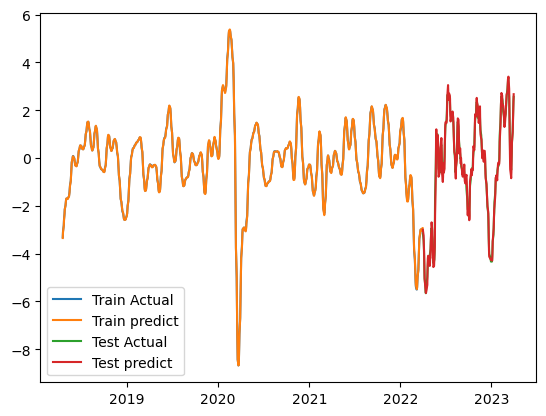

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 4ms/step
Train_MAE: 0.006222893763333559
Test_MAE: 0.021987343579530715


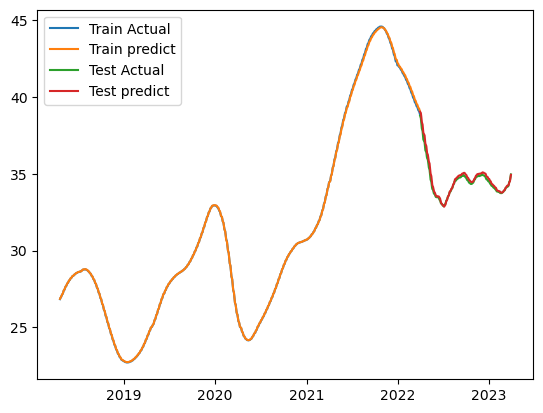

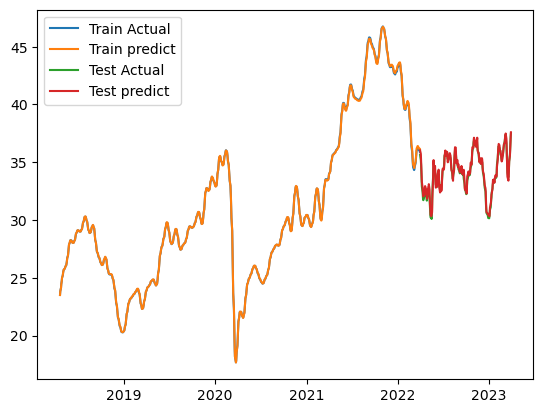

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.027022998966276645
Test_MAE: 0.12827883809804916


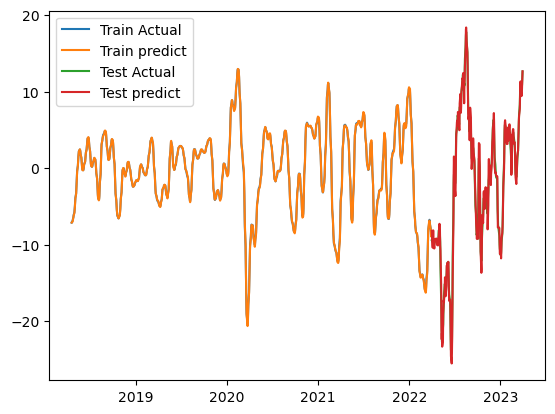

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.009825491718947888
Test_MAE: 0.034279003366827966


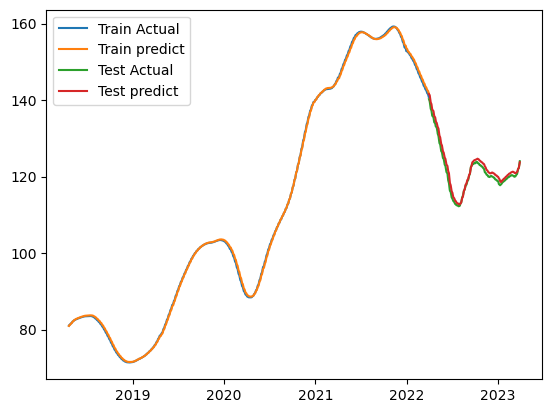

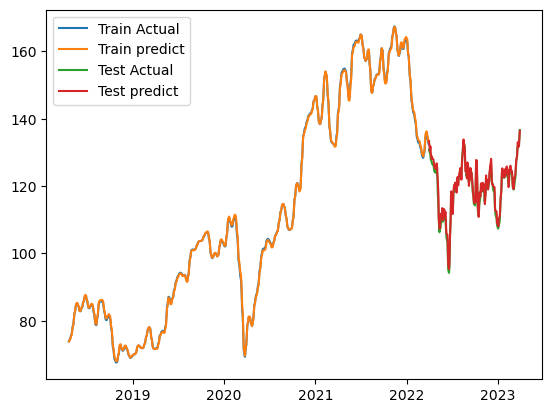

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.015521198324859143
Test_MAE: 0.03914483189582825


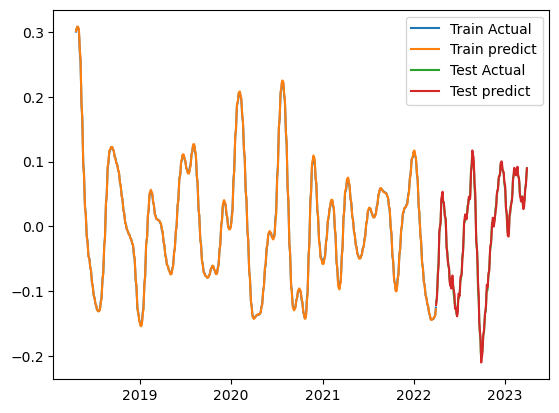

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 4ms/step
Train_MAE: 0.006879728729836642
Test_MAE: 0.019757474353536964


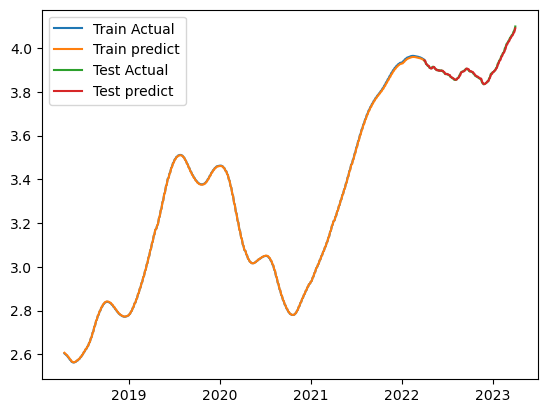

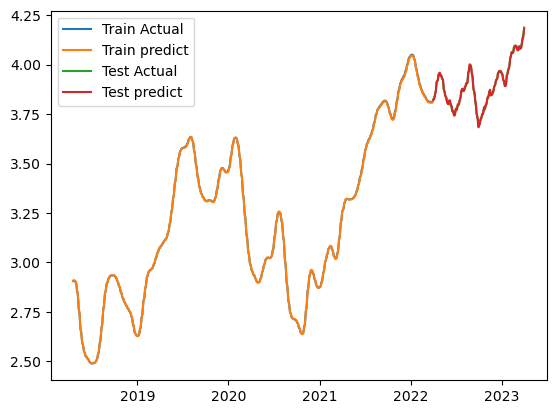

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 4ms/step
Train_MAE: 0.033747156336903575
Test_MAE: 0.09590860158205032


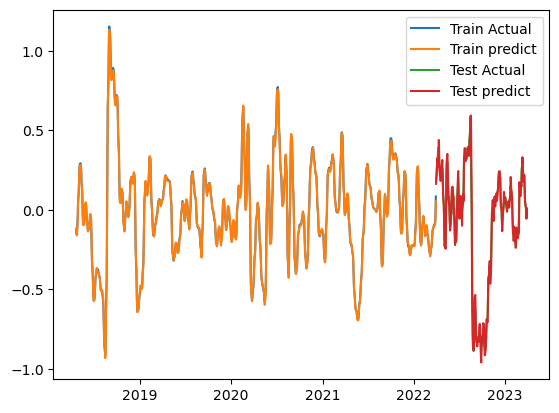

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 4ms/step
Train_MAE: 0.00805741287767887
Test_MAE: 0.018738945946097374


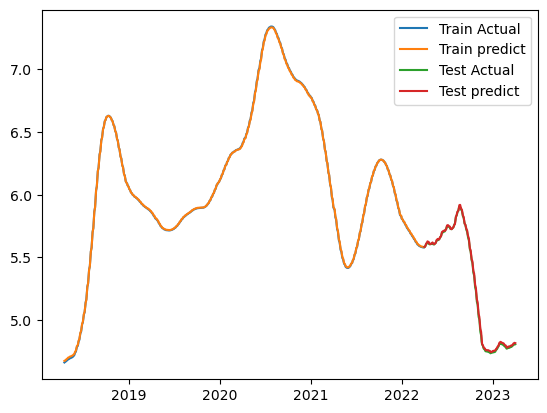

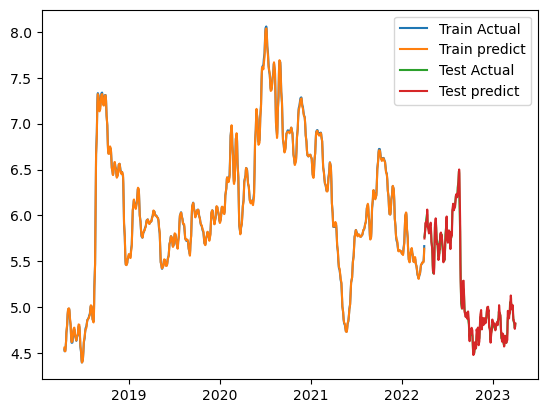

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.013587084040045739
Test_MAE: 0.06534458994865418


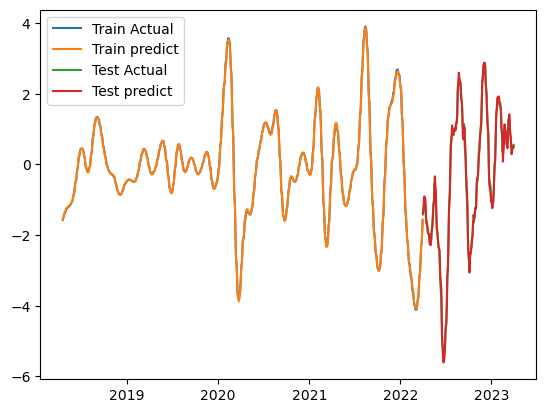

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.00902772881090641
Test_MAE: 0.02042543385177851


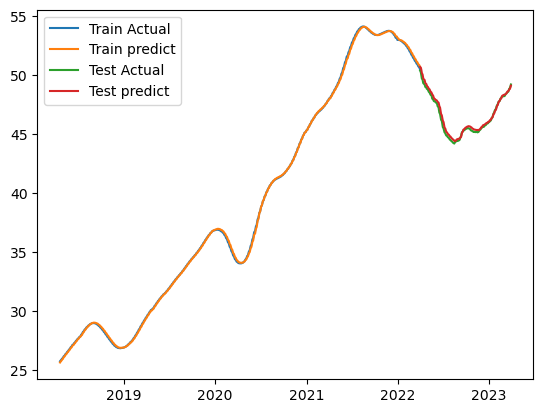

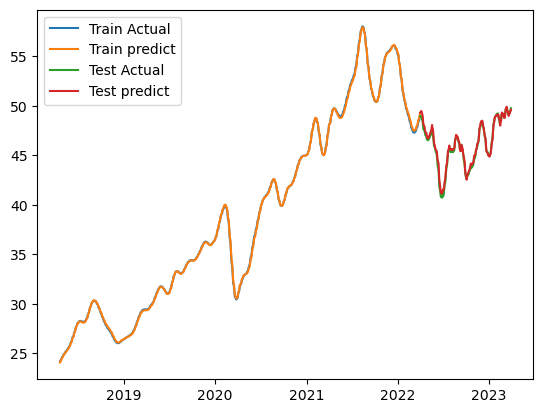

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 4ms/step
Train_MAE: 0.016415845416486264
Test_MAE: 0.05594371557235718


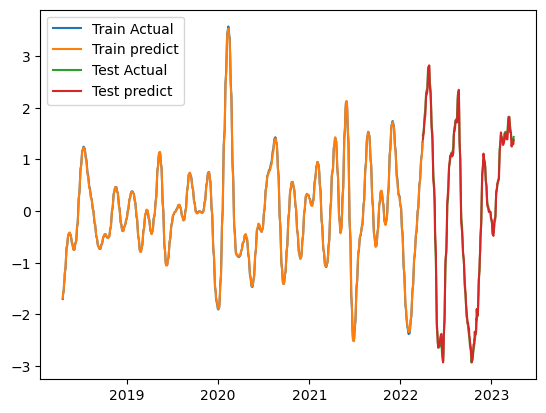

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 4ms/step
Train_MAE: 0.0089386778883636
Test_MAE: 0.014952766336500644


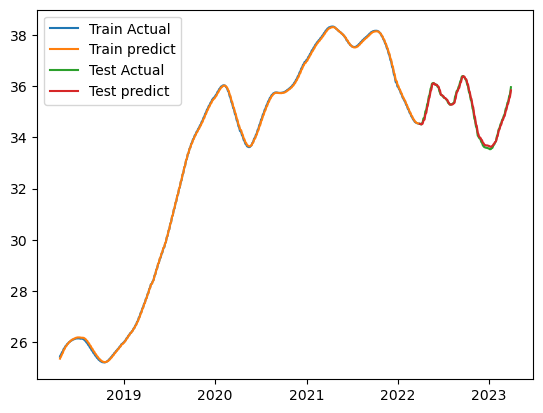

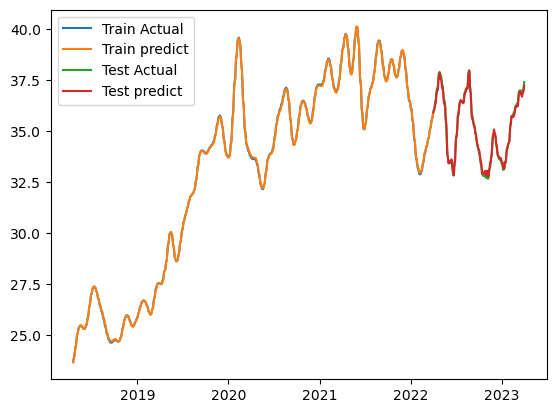

In [ ]:
obtain_all(0, show = True)

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.025171829387545586
Test_MAE: 0.07502923011779786


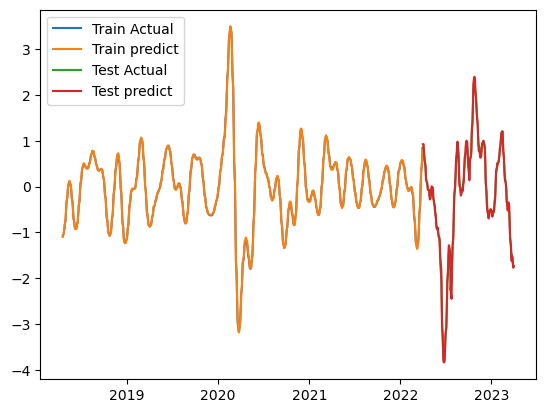

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.002632486866787076
Test_MAE: 0.009217183943837881


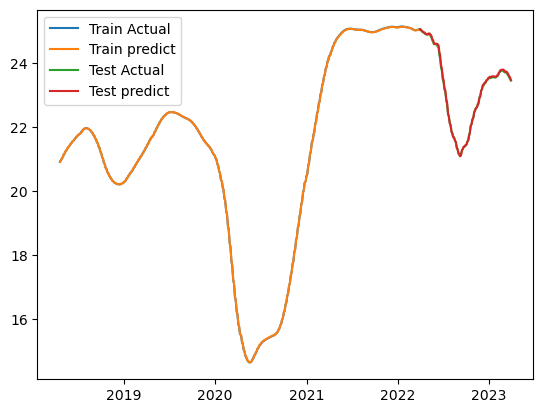

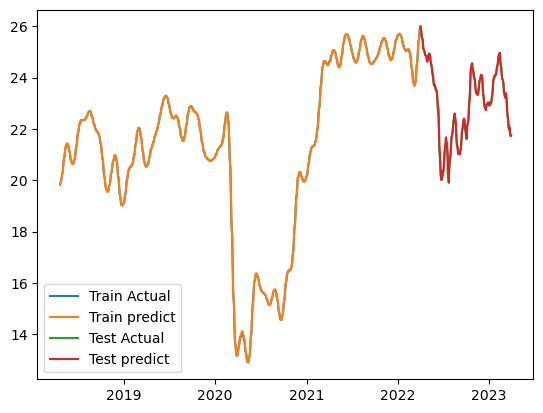

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.021509110927581787
Test_MAE: 0.06099074110388756


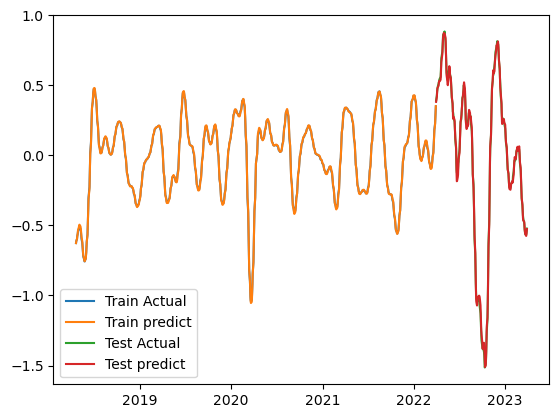

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.0051485997624695305
Test_MAE: 0.014950131438672543


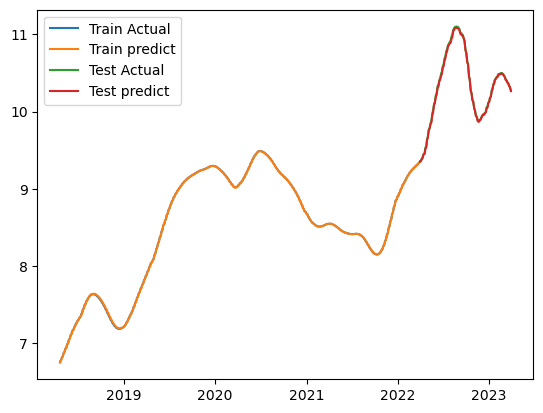

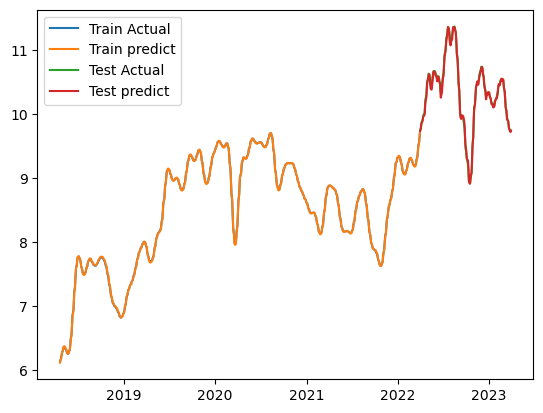

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.017506588809192182
Test_MAE: 0.062085970491170886


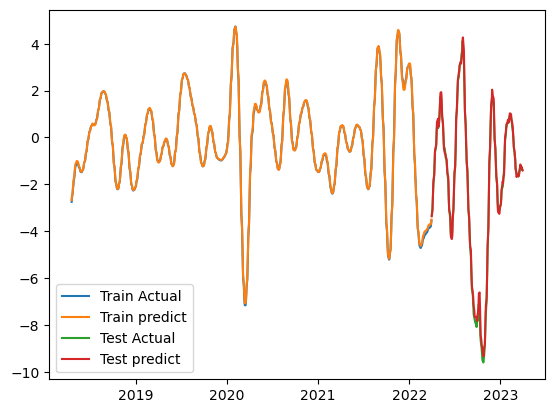

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.004523349134251476
Test_MAE: 0.004607957787811756


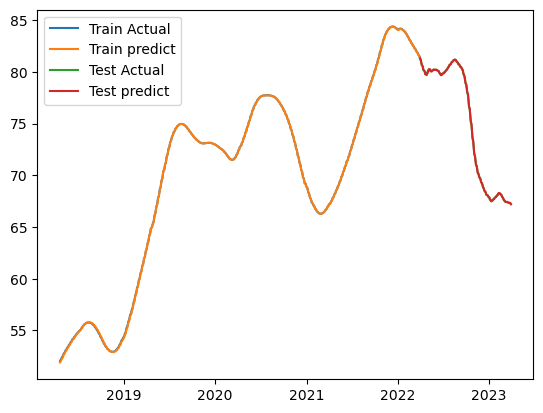

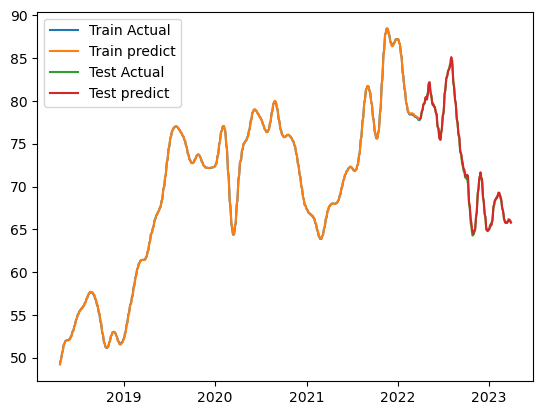

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.019955442287027836
Test_MAE: 0.06859848946332932


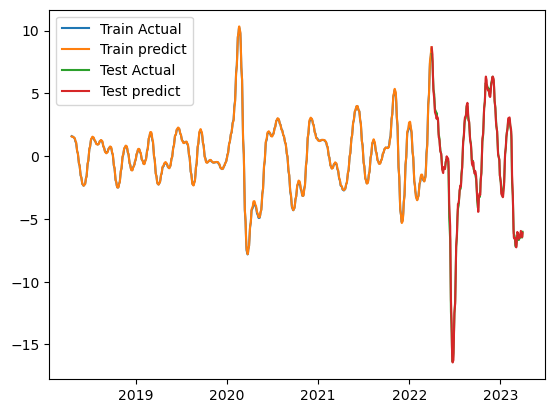

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 4ms/step
Train_MAE: 0.005164024513214826
Test_MAE: 0.022407009452581405


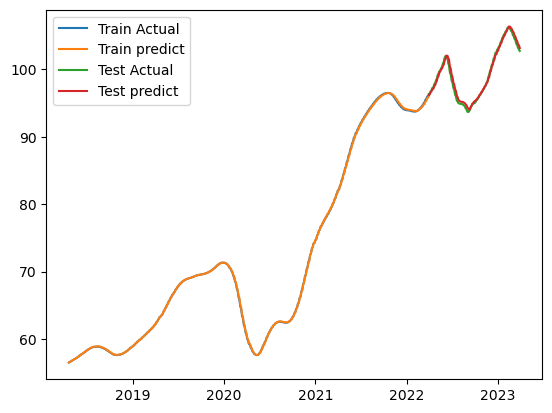

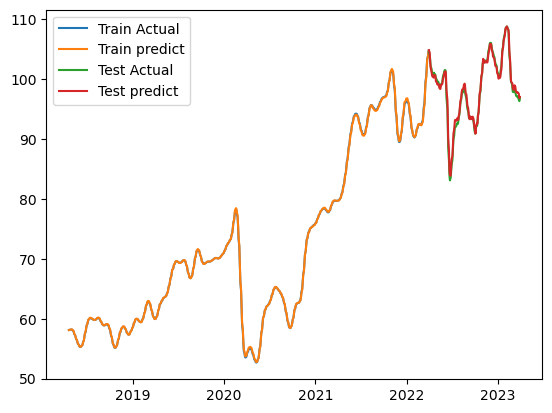

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.01235904786735773
Test_MAE: 0.0953429475426674


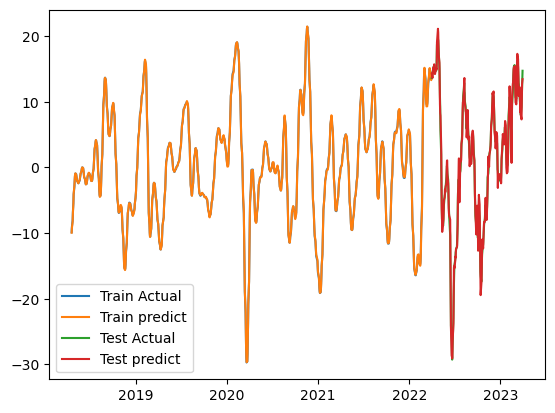

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.004487487953156233
Test_MAE: 0.008714487589895726


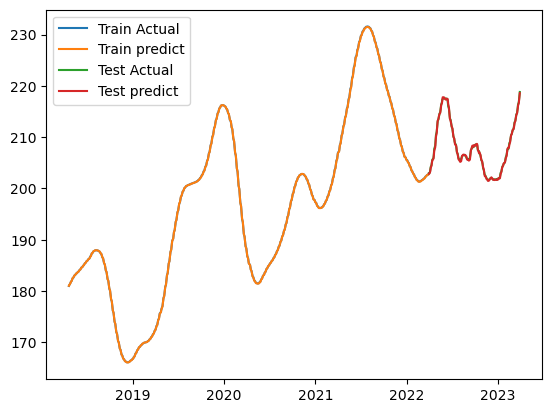

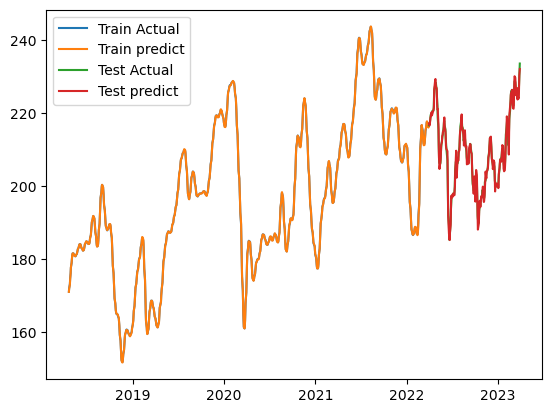

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.020700263790786266
Test_MAE: 0.10372478812932968


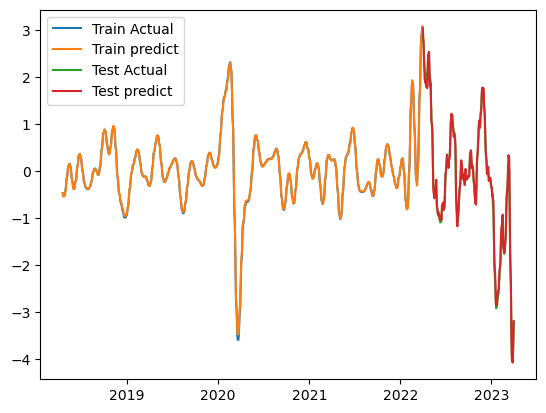

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.003458311595022678
Test_MAE: 0.031166652217507362


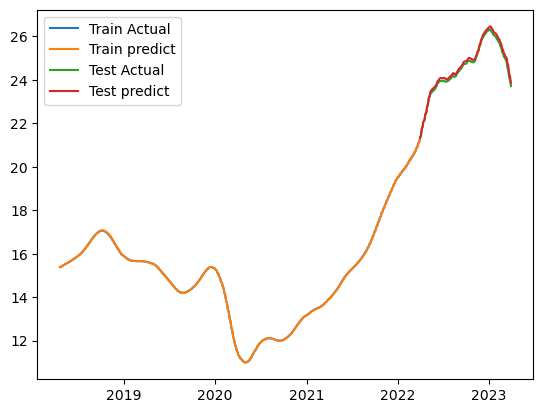

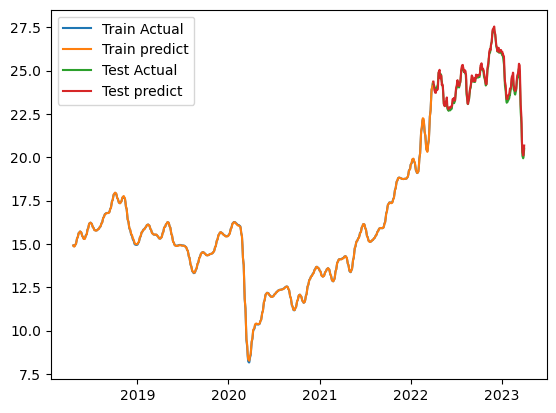

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.024540484882891178
Test_MAE: 0.07206580489873886


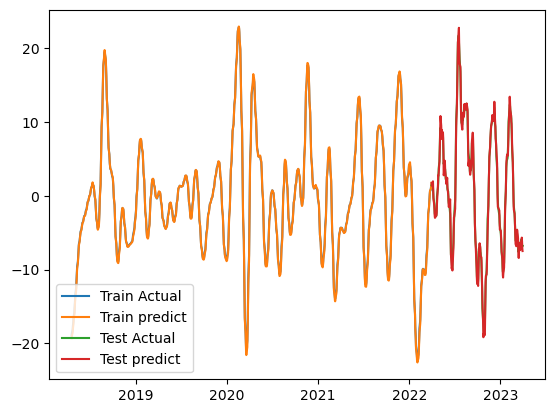

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.010755221545696258
Test_MAE: 0.009643383696675301


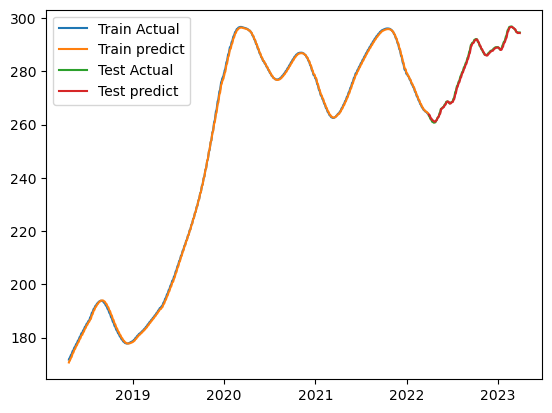

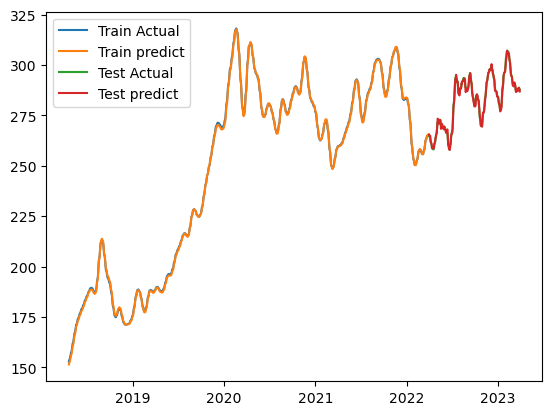

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.025989266112446785
Test_MAE: 0.09266998022794723


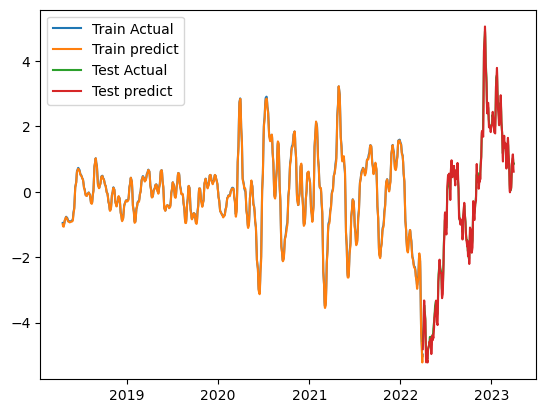

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.007600714918226004
Test_MAE: 0.03149257004261017


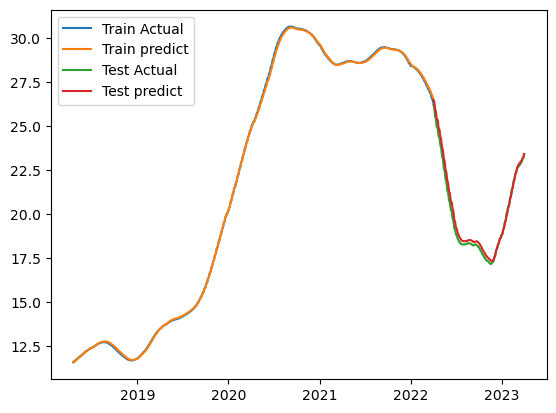

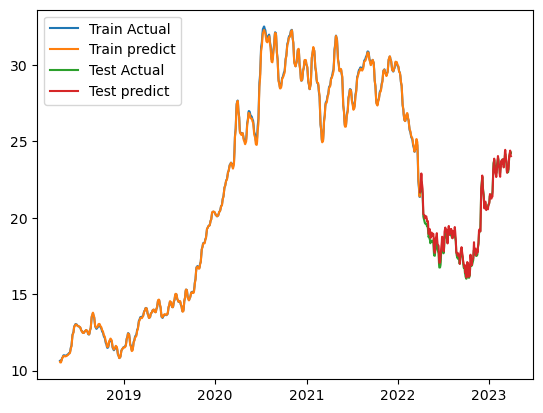

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.019933624751865865
Test_MAE: 0.09973588734865188


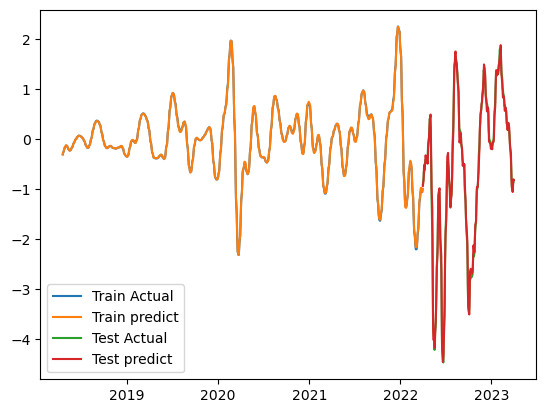

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.008908550720661879
Test_MAE: 0.029328851029276848


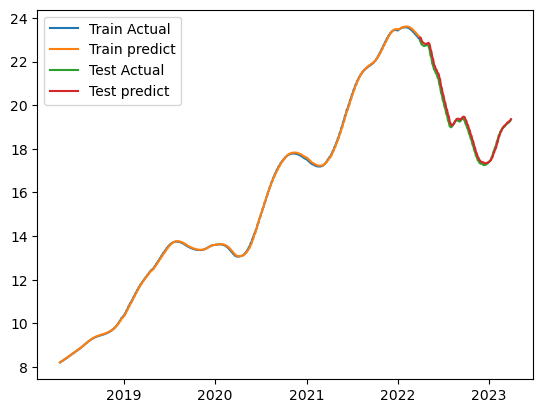

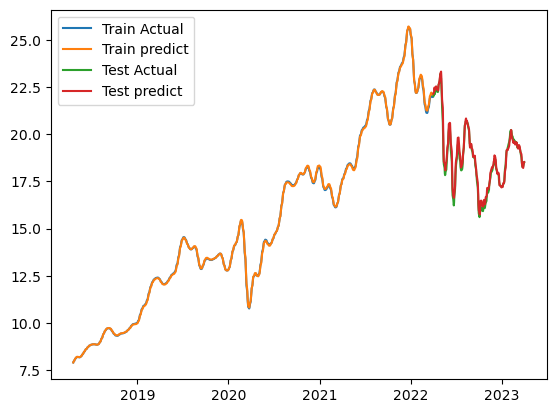

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.020707909017801285
Test_MAE: 0.05703872516751289


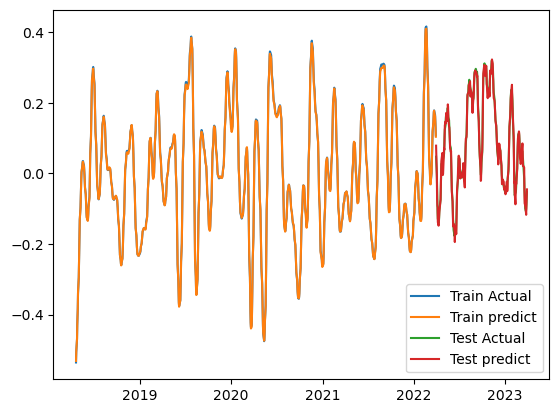

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.008798852190375328
Test_MAE: 0.015134515799582004


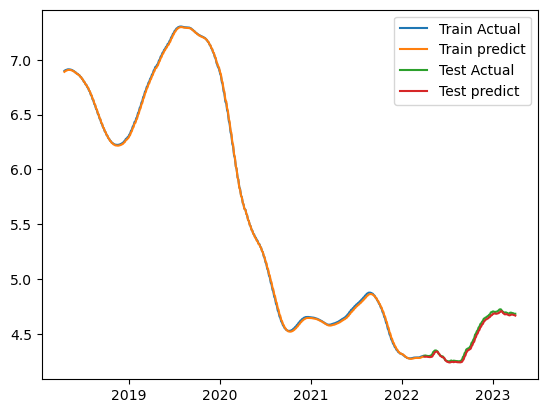

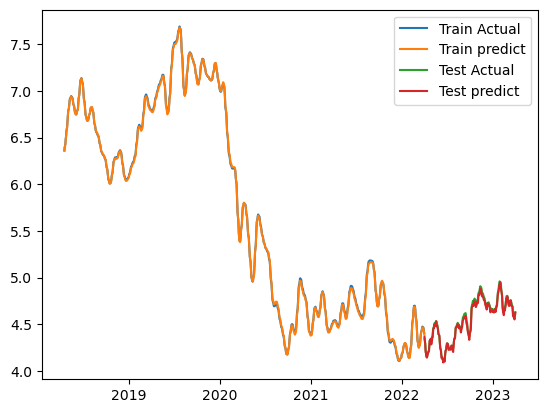

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.02017555311322212
Test_MAE: 0.08565787225961685


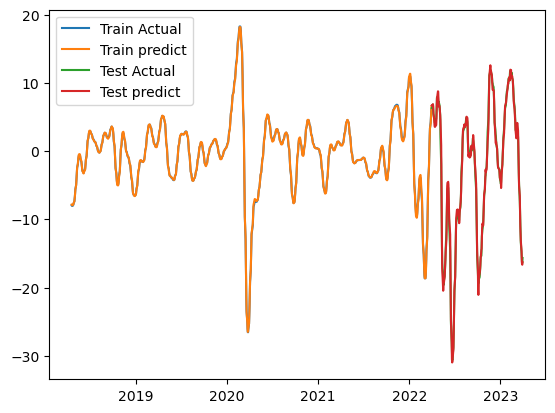

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.008089725766330958
Test_MAE: 0.04113631993532181


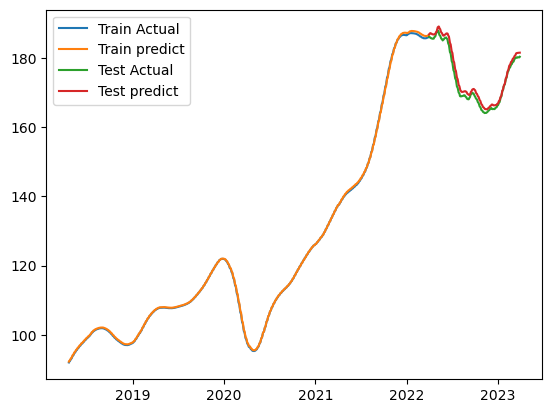

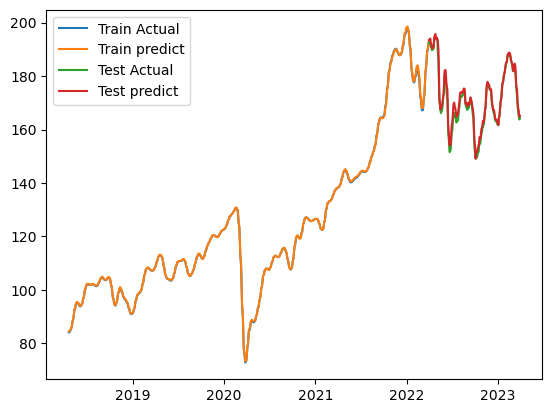

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.02522439807653427
Test_MAE: 0.09504674673080445


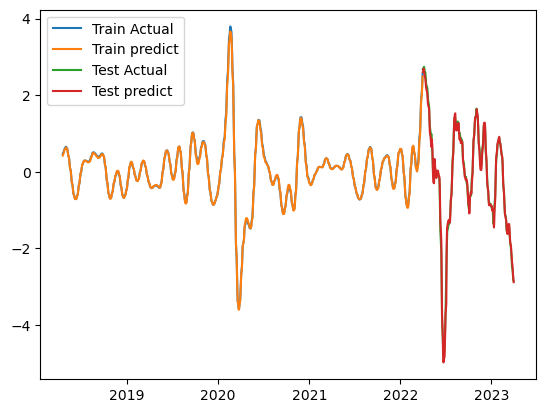

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.0035643790382891894
Test_MAE: 0.017595117166638374


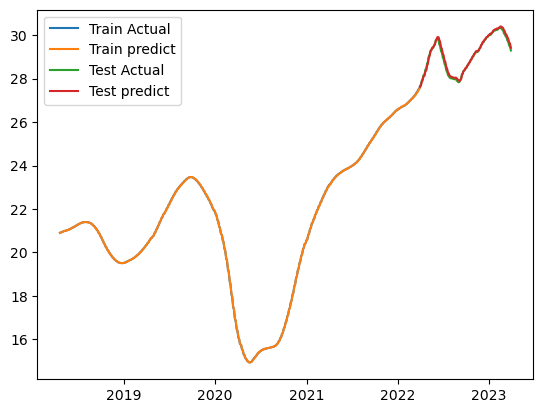

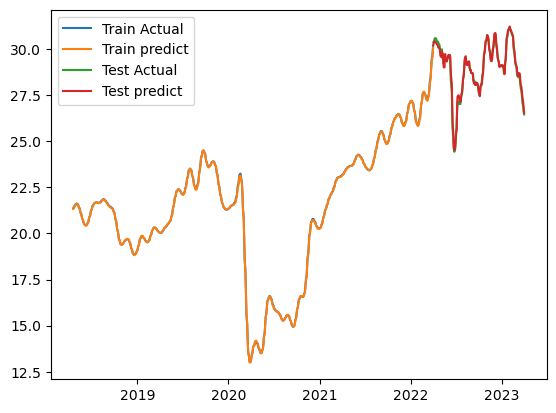

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 2ms/step
Train_MAE: 0.014562626928091049
Test_MAE: 0.0843818798661232


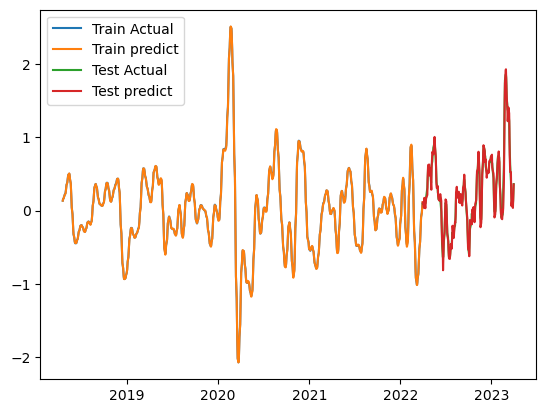

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.0038283554837107658
Test_MAE: 0.012602321803569794


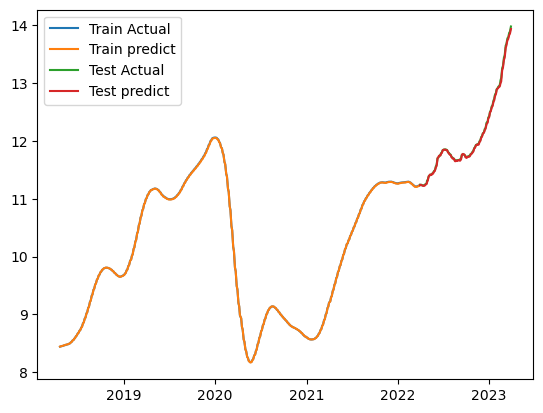

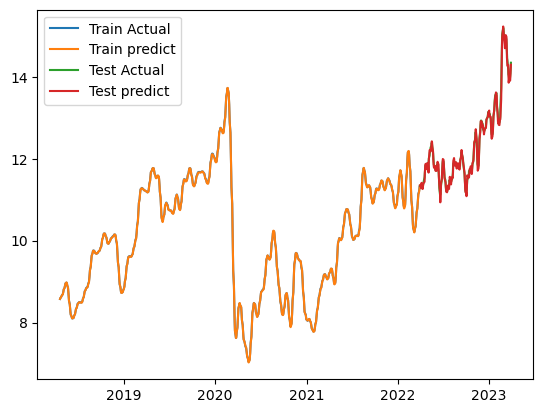

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.023225198313593865
Test_MAE: 0.10886046439409255


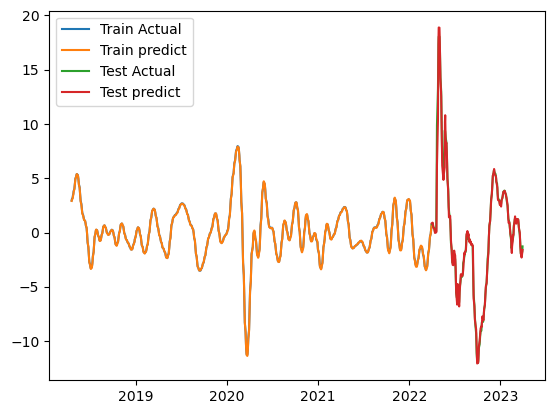

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.007045599911361933
Test_MAE: 0.013089357502758503


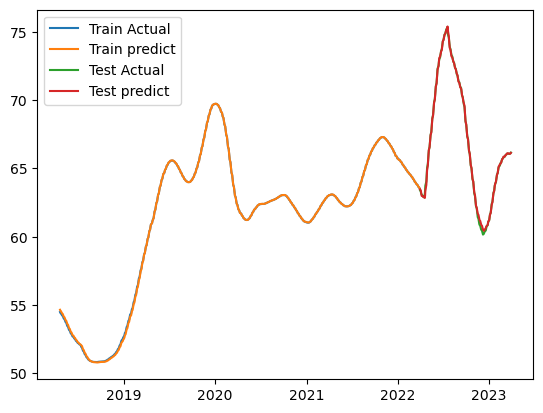

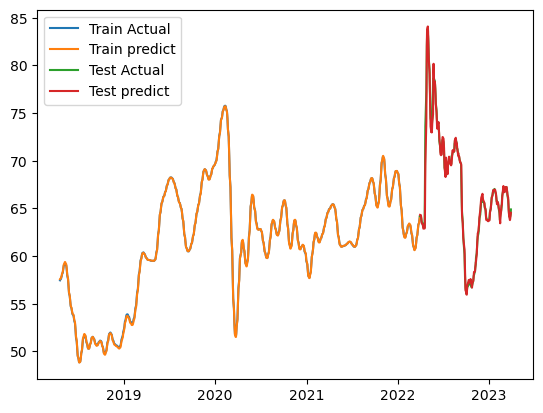

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 4ms/step
Train_MAE: 0.018820215947926044
Test_MAE: 0.09969831556081772


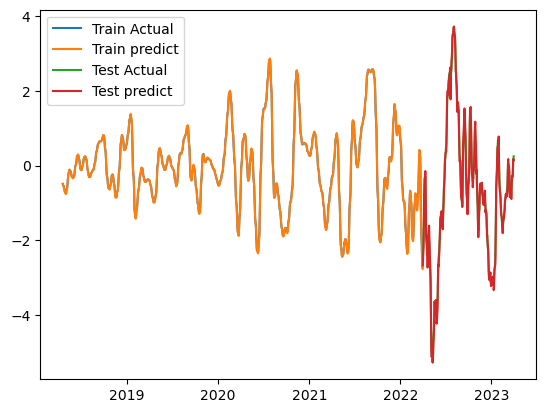

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.00884103449061513
Test_MAE: 0.021021439321339132


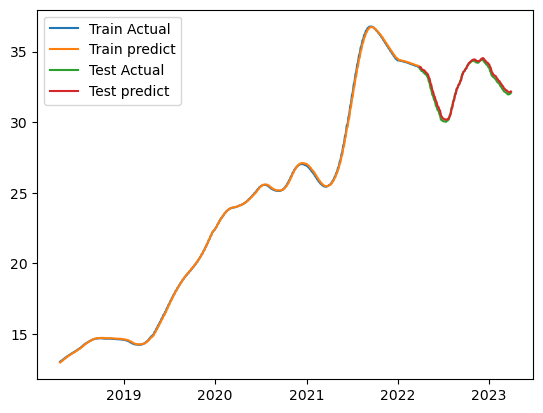

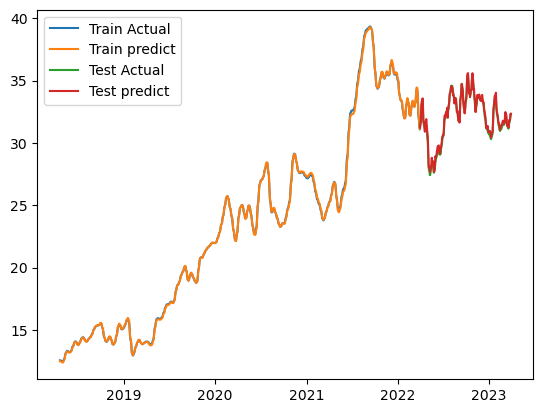

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.02417914420366287
Test_MAE: 0.07852763235569


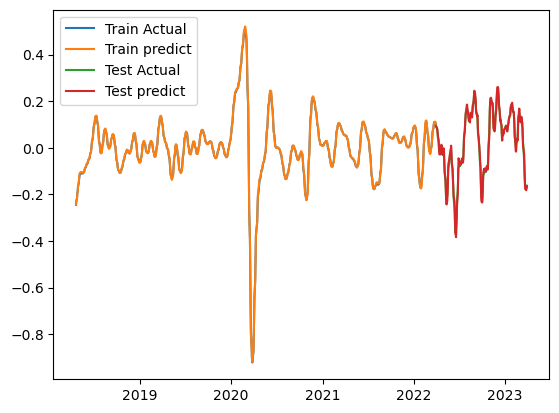

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.0037802460603415964
Test_MAE: 0.00694931298494339


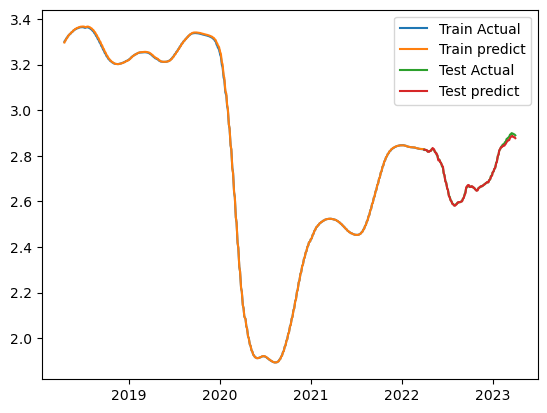

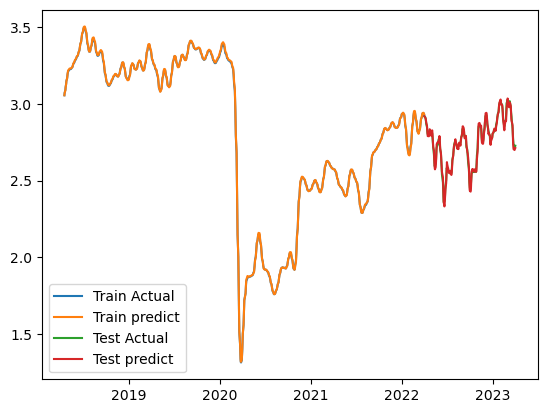

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.01903729997575283
Test_MAE: 0.06426863372325897


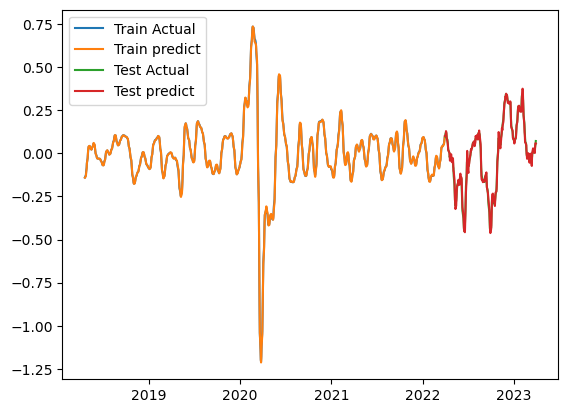

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.006264104065485299
Test_MAE: 0.00670666117221117


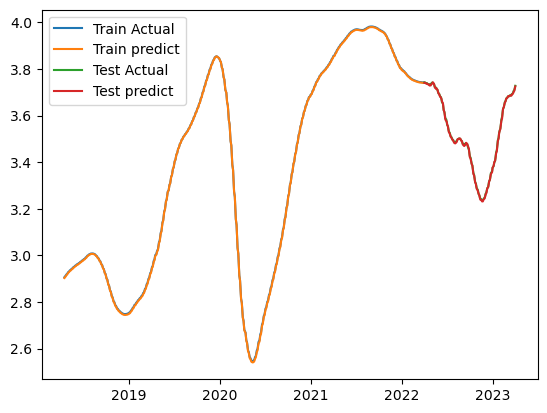

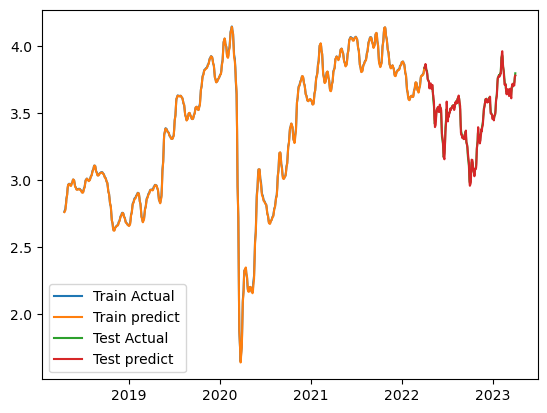

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.023673648200929164
Test_MAE: 0.0713576465845108


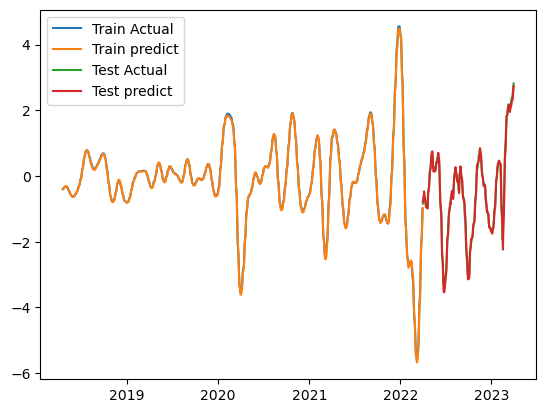

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 4ms/step
Train_MAE: 0.010496749728918075
Test_MAE: 0.02446344867348671


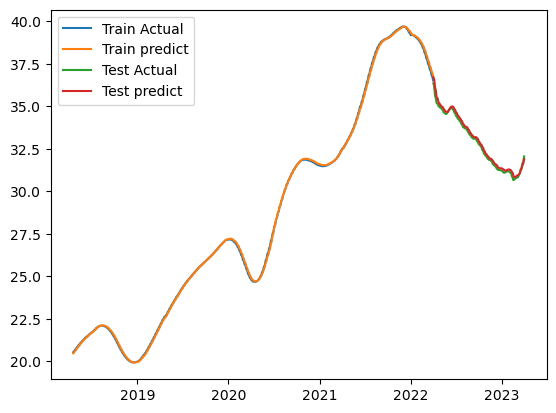

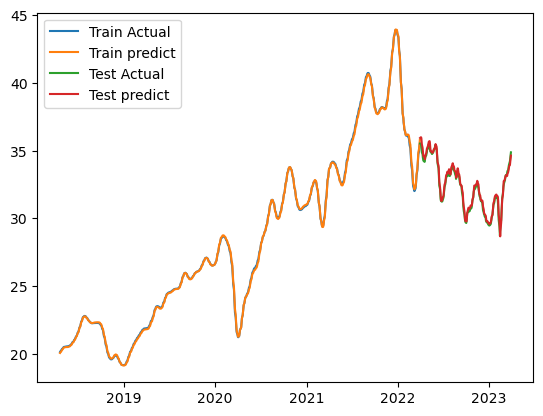

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.013828951492905616
Test_MAE: 0.07053454816341401


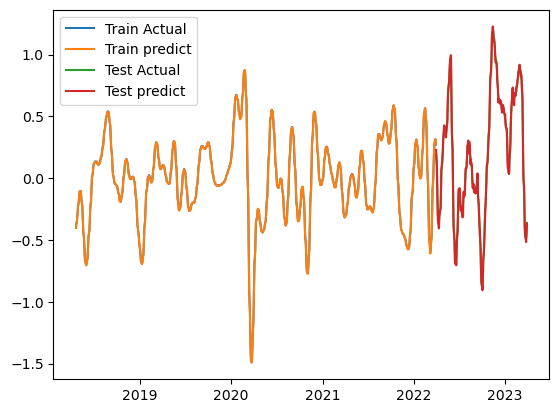

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.004932587966322899
Test_MAE: 0.004819904081523418


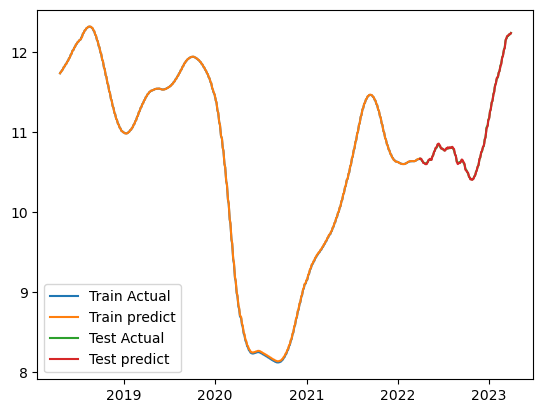

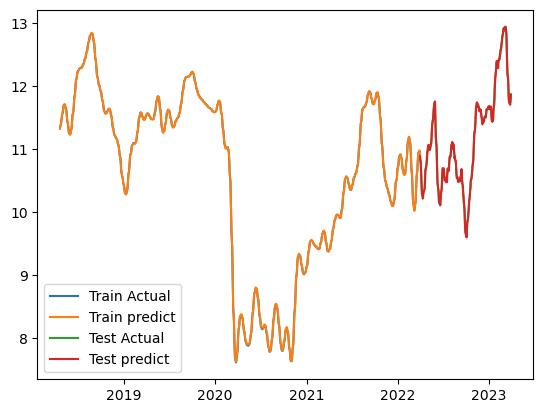

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 5ms/step
Train_MAE: 0.014345785975456238
Test_MAE: 0.05761057287454605


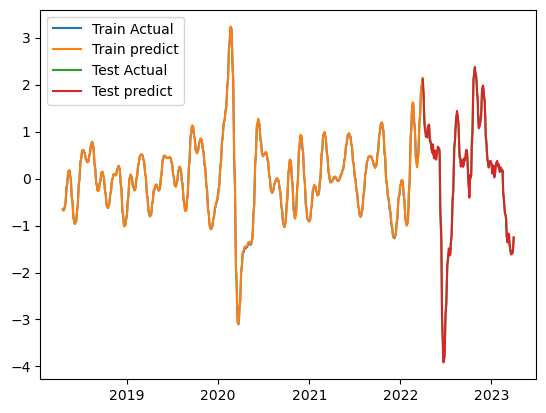

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.003034527087584138
Test_MAE: 0.0040940756909549235


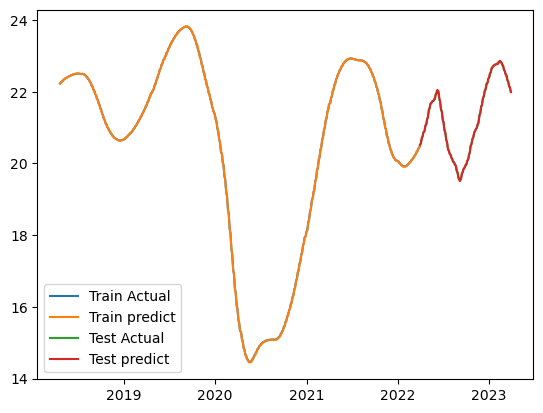

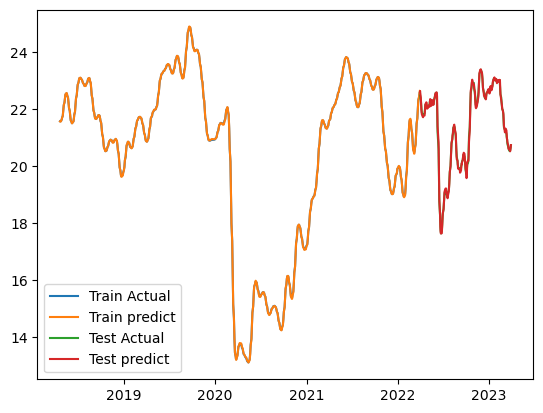

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.054368512332439424
Test_MAE: 0.34803042411804197


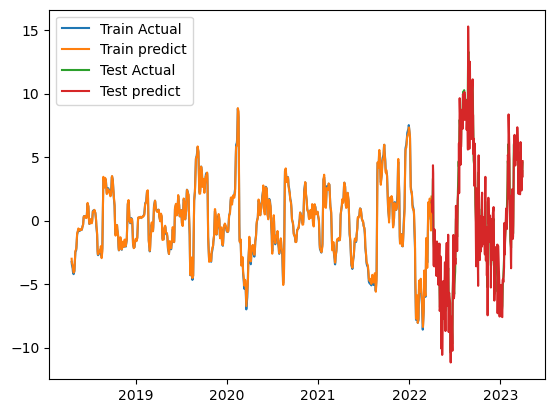

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.006254192534834146
Test_MAE: 0.03737650476396084


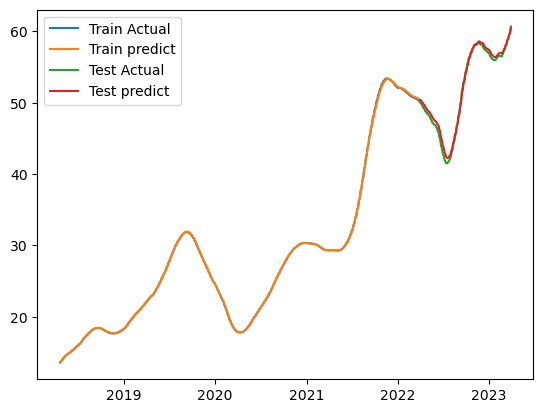

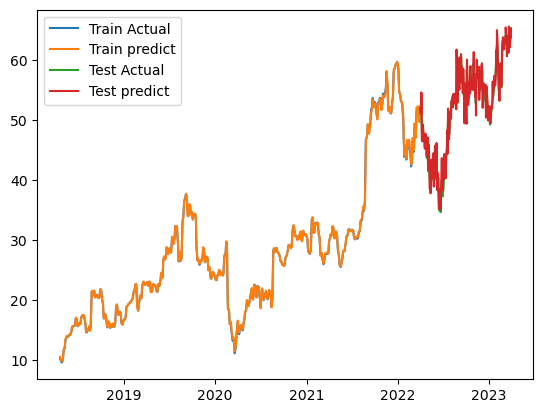

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.029215523973107338
Test_MAE: 0.14940371215343476


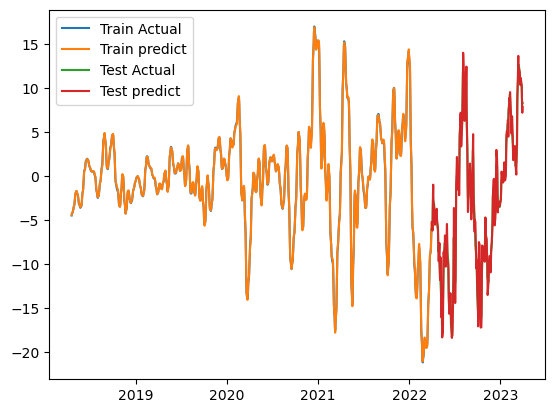

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.009509679861366749
Test_MAE: 0.022756373137235643


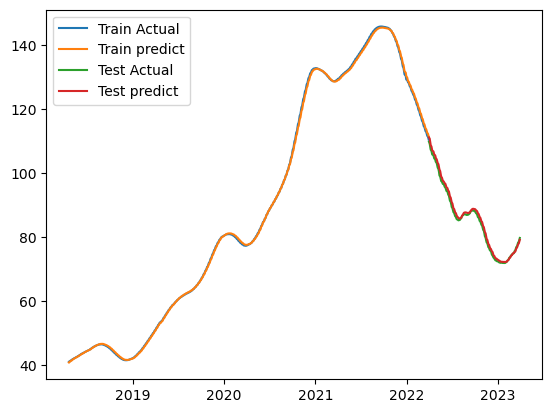

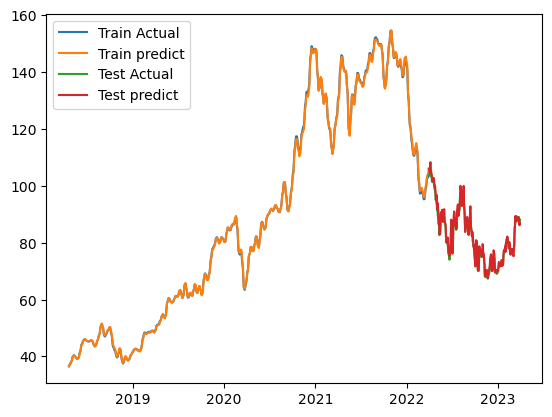

In [ ]:
obtain_all(1, show = True)

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 4ms/step
Train_MAE: 0.025641433894634247
Test_MAE: 0.06735908091068268


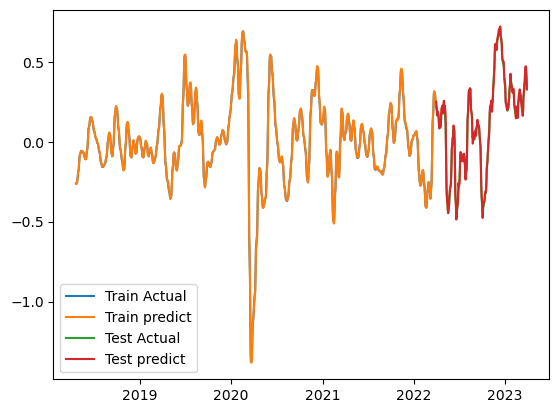

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.0035352893872186543
Test_MAE: 0.004533900832757354


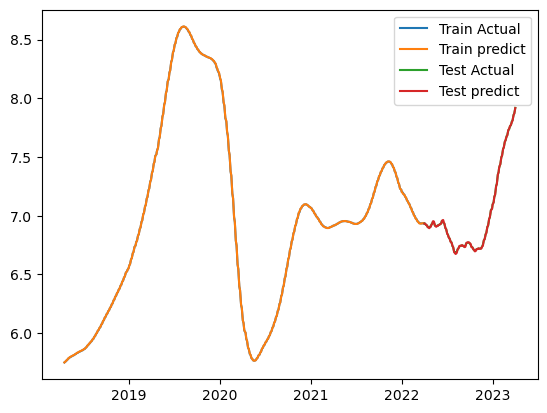

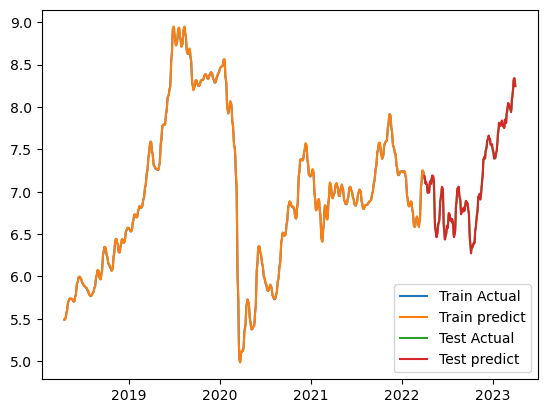

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 4ms/step
Train_MAE: 0.0136167474091053
Test_MAE: 0.10923065692186355


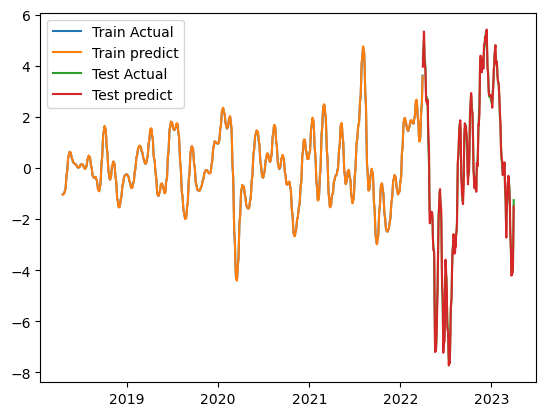

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.013720402680337428
Test_MAE: 0.027418632805347443


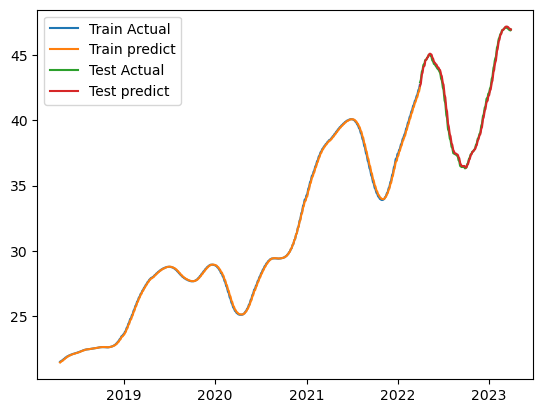

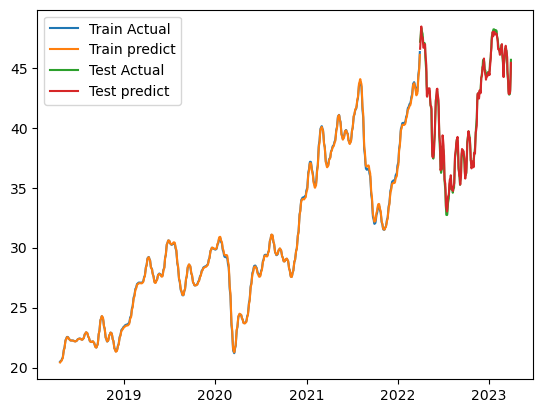

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.016976976953446864
Test_MAE: 0.0574839748442173


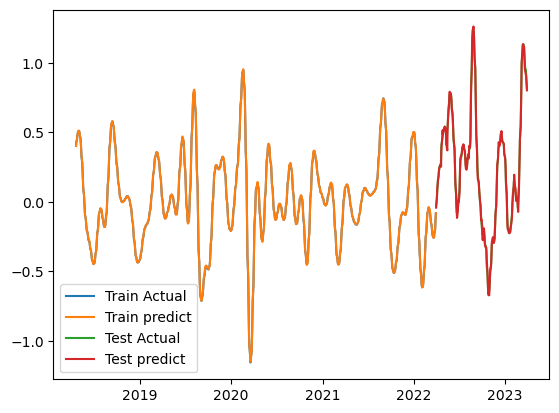

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.006914312485605478
Test_MAE: 0.014694079756736755


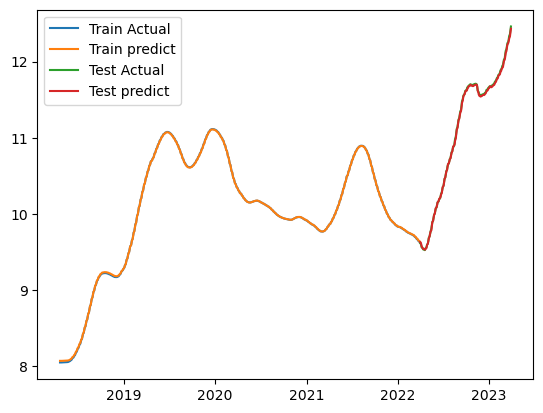

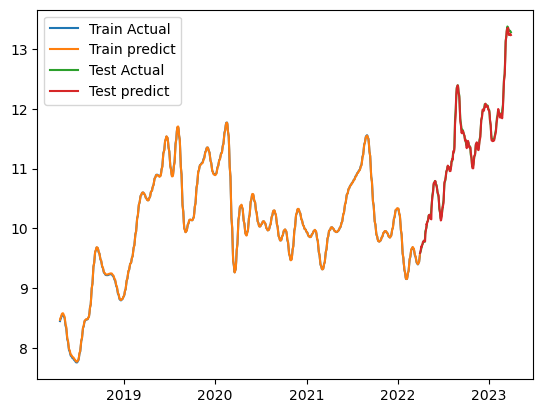

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 5ms/step
Train_MAE: 0.02969698831439018
Test_MAE: 0.22303085923194885


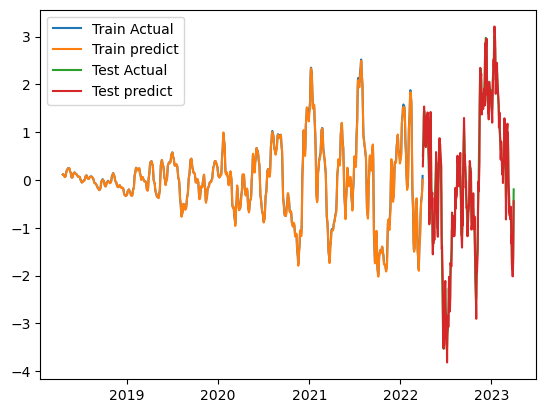

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.007559663150459528
Test_MAE: 0.016642524488270284


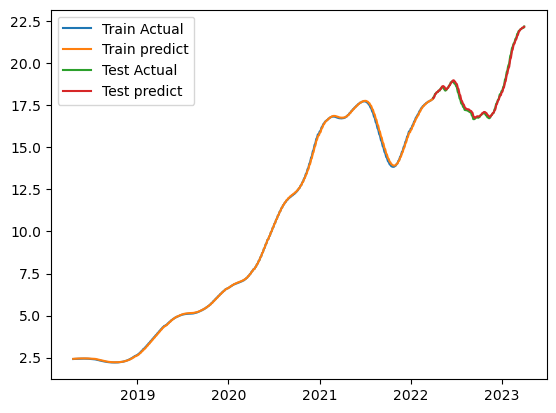

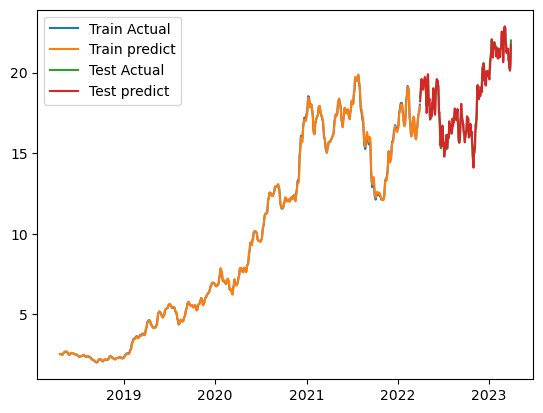

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 4ms/step
Train_MAE: 0.030110609903931617
Test_MAE: 0.3049603343009949


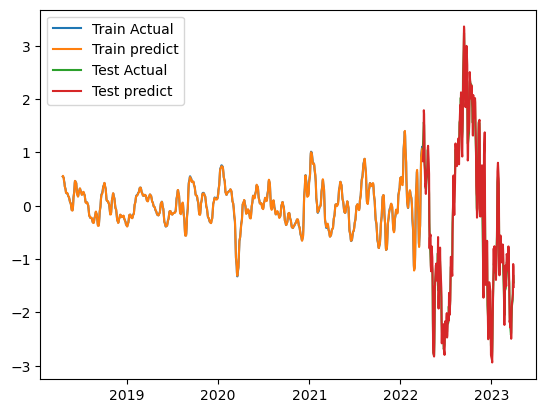

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.004929153015837073
Test_MAE: 0.06018039658665657


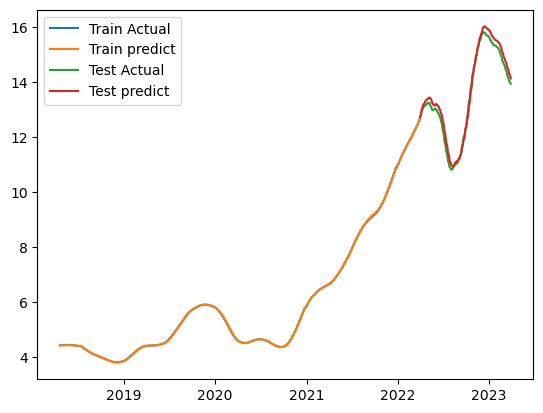

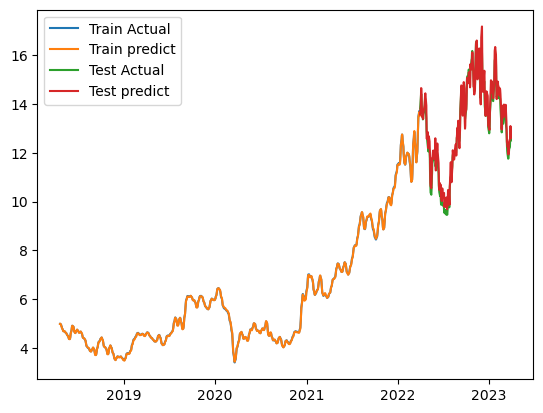

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.013590840995311737
Test_MAE: 0.1005061537027359


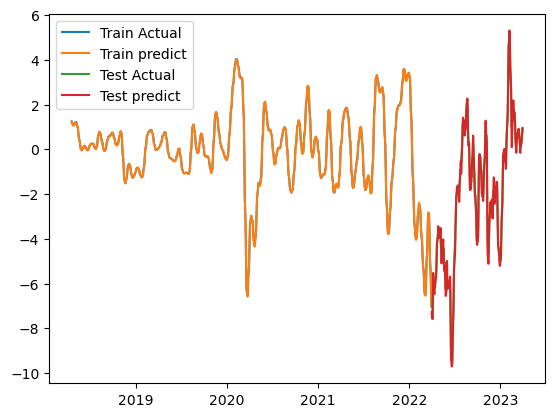

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.009943097271025181
Test_MAE: 0.03177855610847473


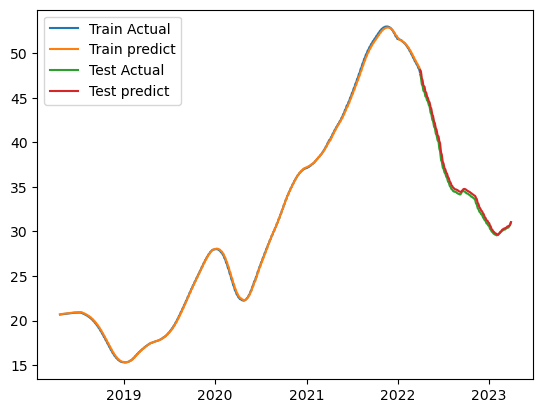

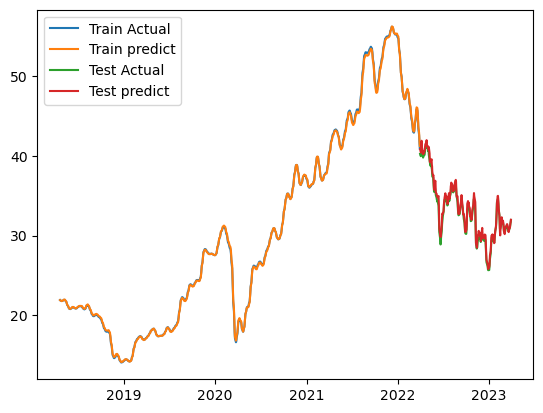

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.042111233621835706
Test_MAE: 0.3364297389984131


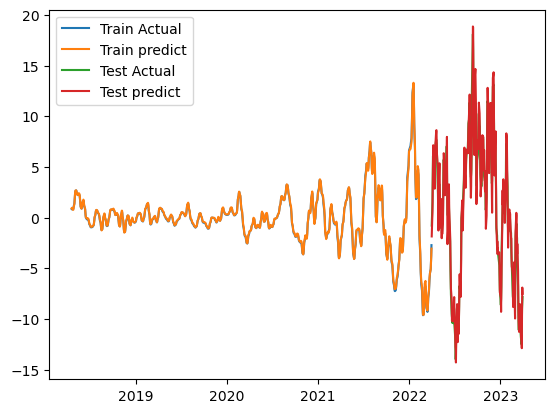

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.008067740499973297
Test_MAE: 0.03376483581960201


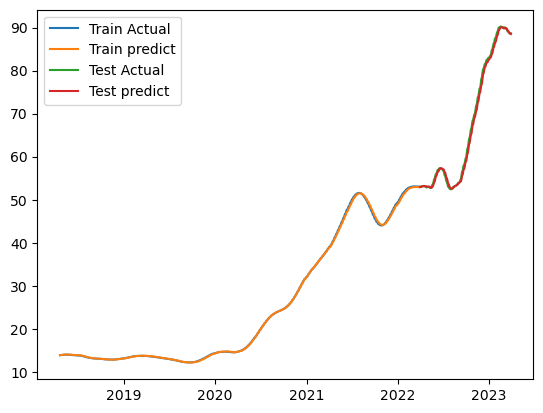

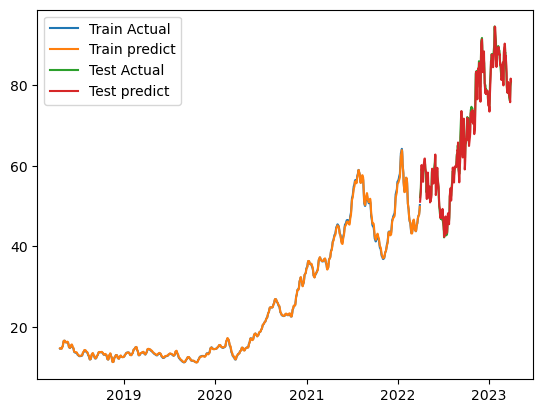

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.027638356760144235
Test_MAE: 0.09401392191648483


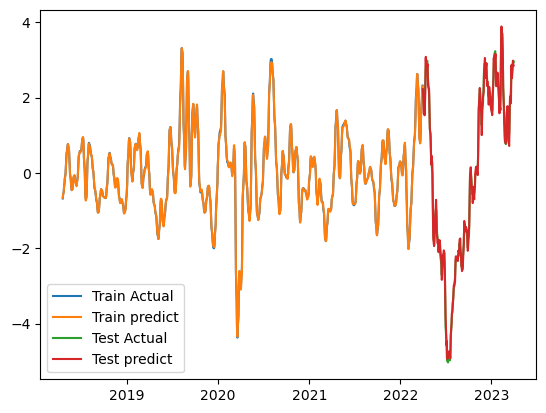

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 2ms/step
Train_MAE: 0.005734365619719029
Test_MAE: 0.018393818847835065


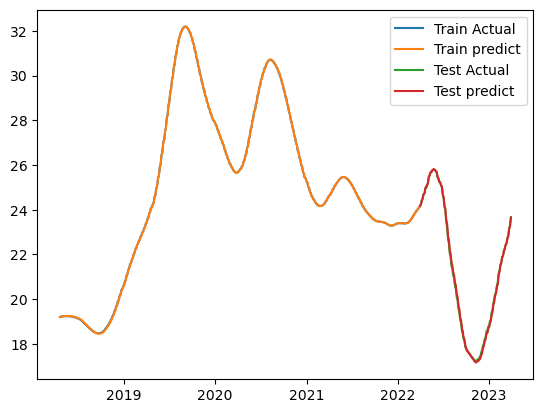

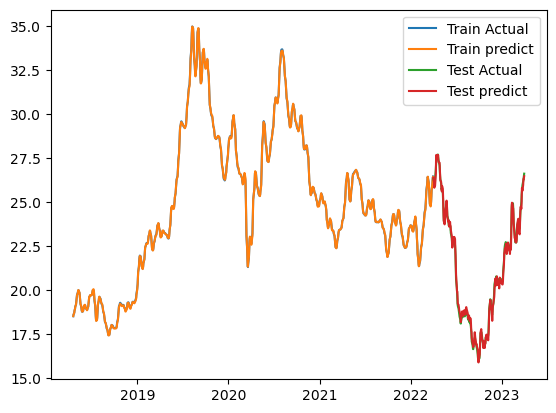

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.056622009724378586
Test_MAE: 0.21777203381061555


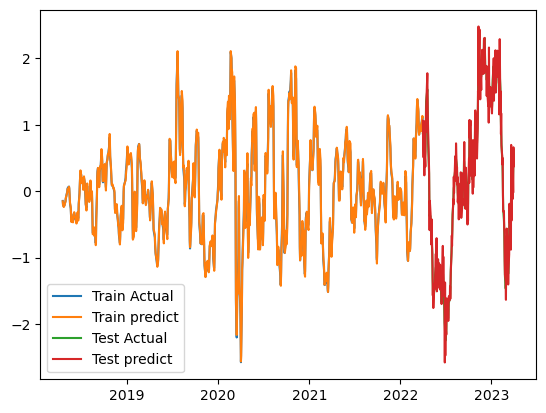

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.005257862852886319
Test_MAE: 0.014087317697703838


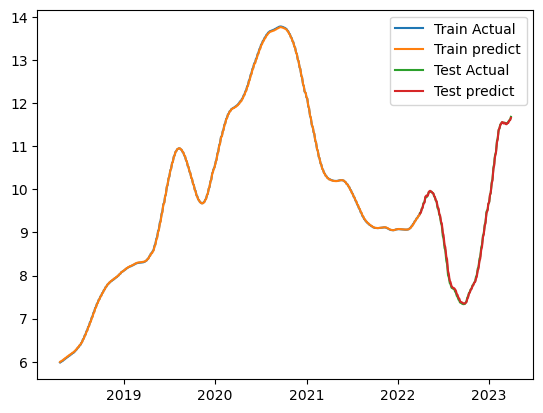

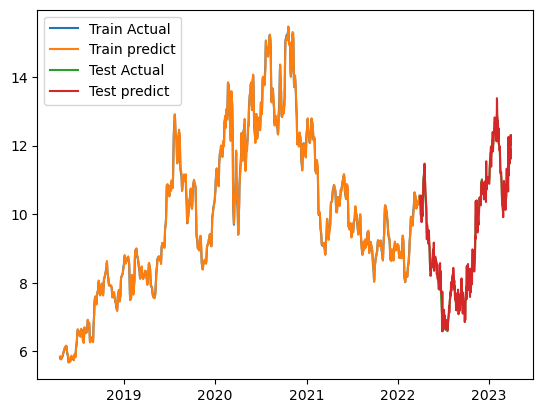

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.021340717747807502
Test_MAE: 0.1307190701365471


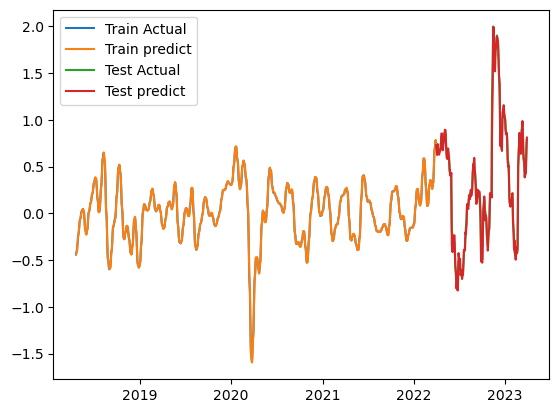

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.0031430546659976244
Test_MAE: 0.01412665992975235


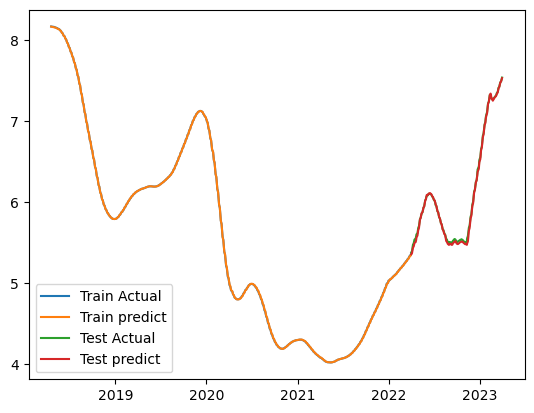

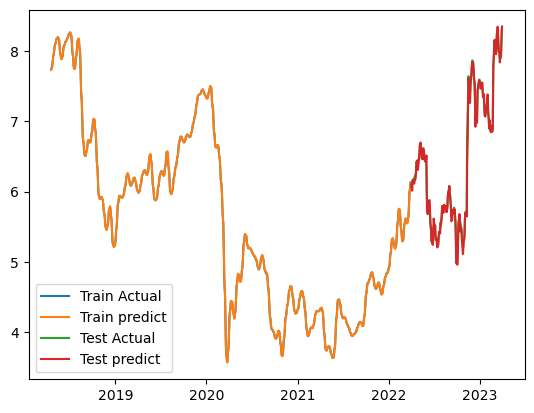

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.08320744633674622
Test_MAE: 0.5386317253112793


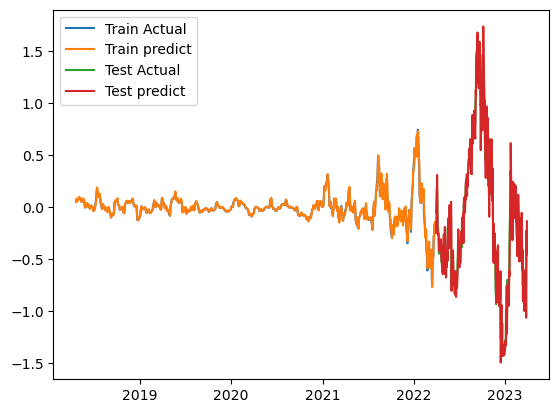

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 4ms/step
Train_MAE: 0.006659107003360987
Test_MAE: 0.06712974086403847


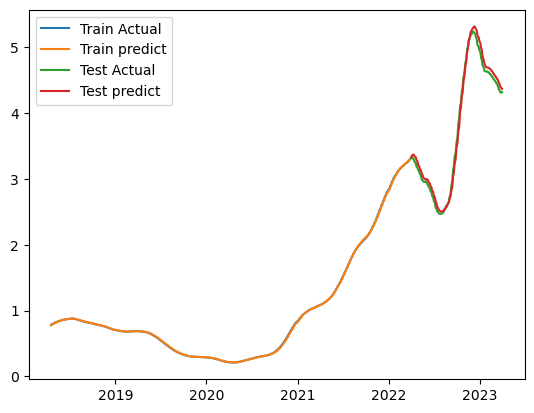

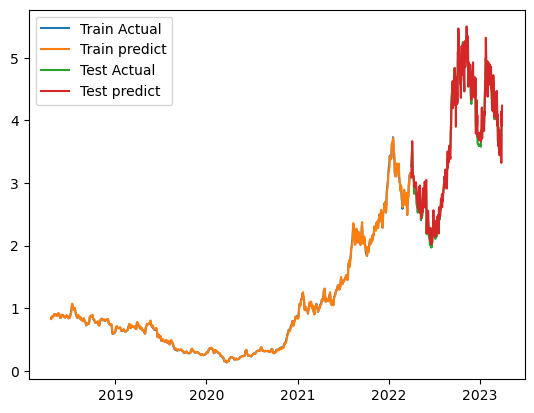

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.030427049100399017
Test_MAE: 0.09544962197542191


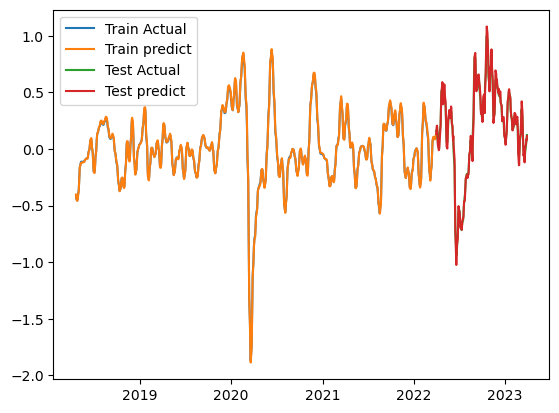

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.005649236310273409
Test_MAE: 0.010725875105708837


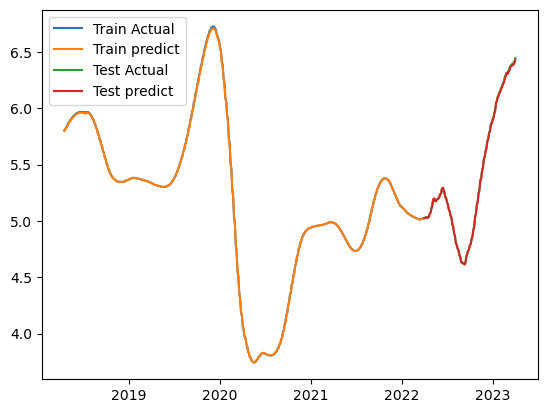

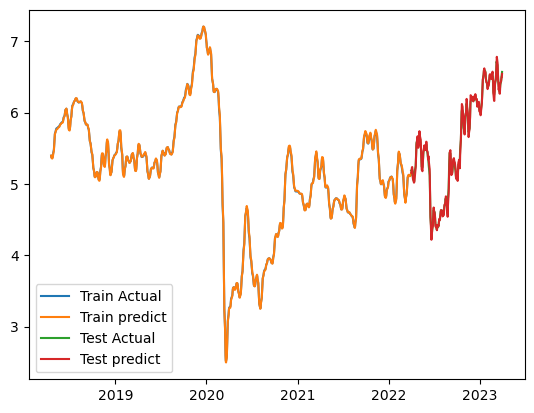

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 4ms/step
Train_MAE: 0.021992262452840805
Test_MAE: 0.09010845869779587


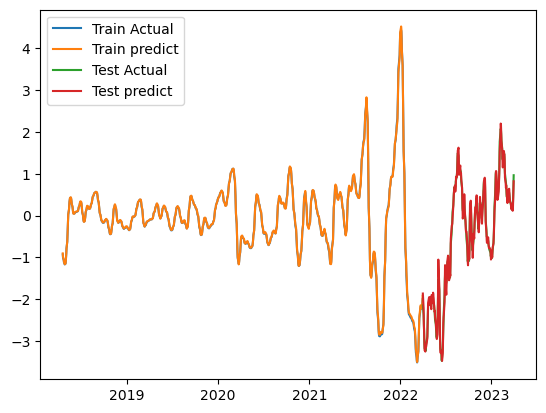

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 4ms/step
Train_MAE: 0.010927414614707231
Test_MAE: 0.030922970548272134


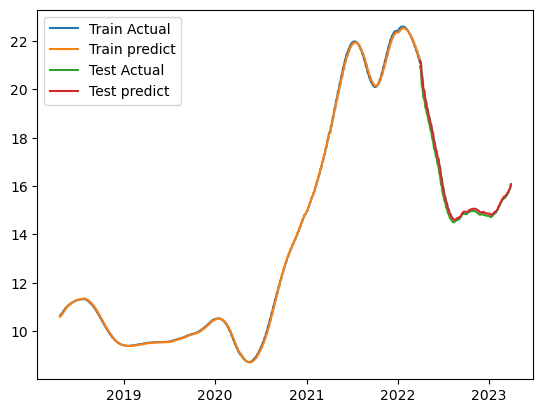

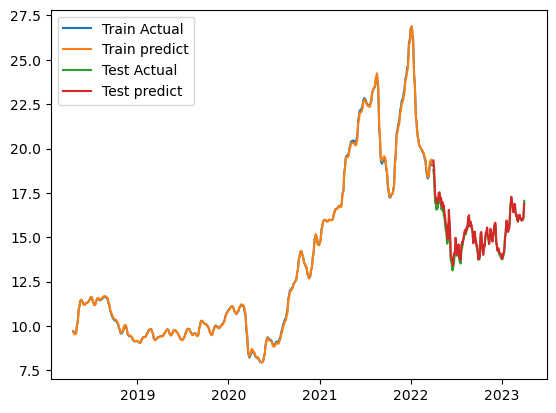

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 4ms/step
Train_MAE: 0.01575419120490551
Test_MAE: 0.10482406467199326


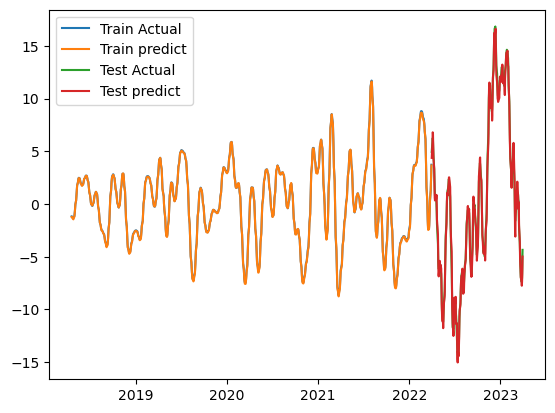

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.0092402926646173
Test_MAE: 0.015389140509068967


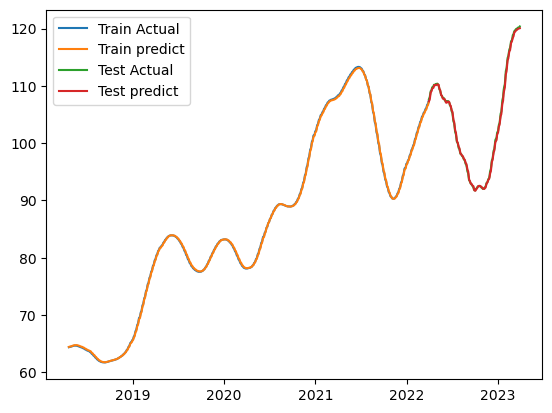

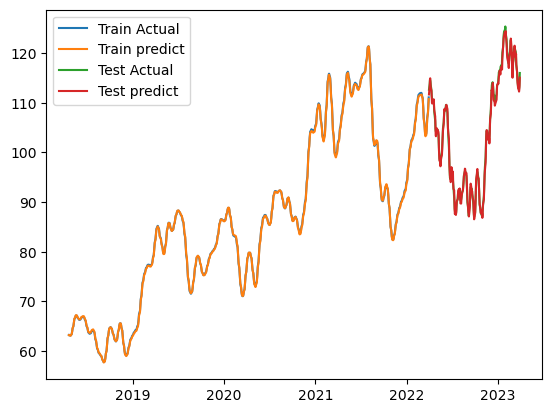

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.026404973492026328
Test_MAE: 0.17543308734893798


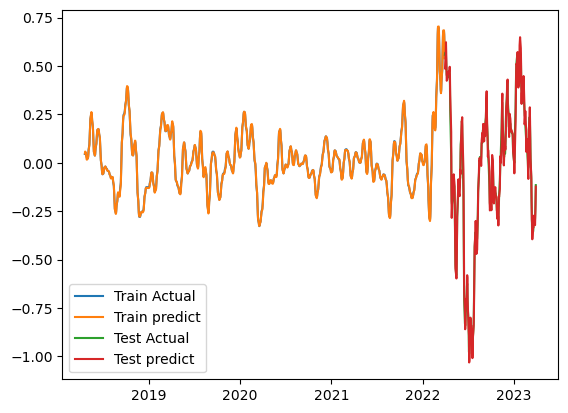

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 4ms/step
Train_MAE: 0.006672405684366822
Test_MAE: 0.019341158866882324


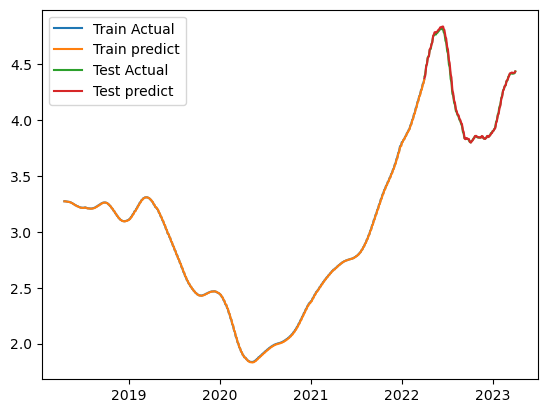

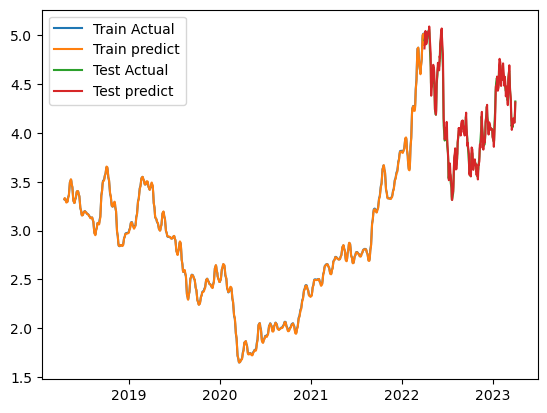

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.019898439384996892
Test_MAE: 0.06840079128742219


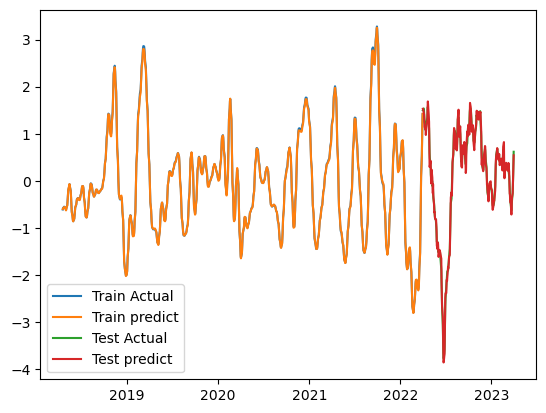

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 4ms/step
Train_MAE: 0.00588693842291832
Test_MAE: 0.007191195897758007


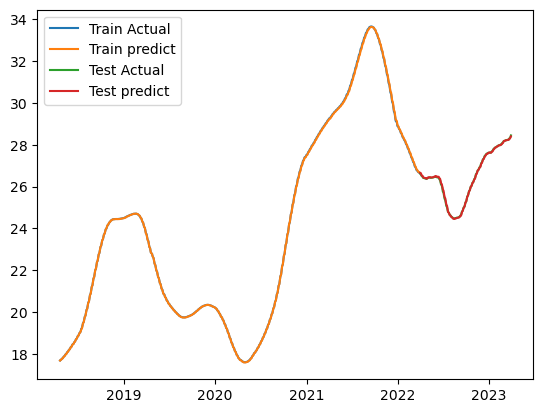

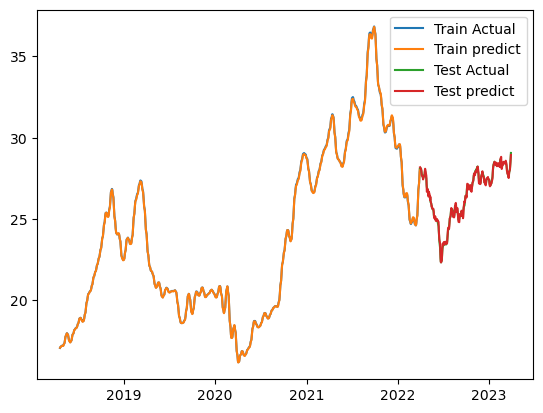

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 4ms/step
Train_MAE: 0.02079210542142391
Test_MAE: 0.11863866597414016


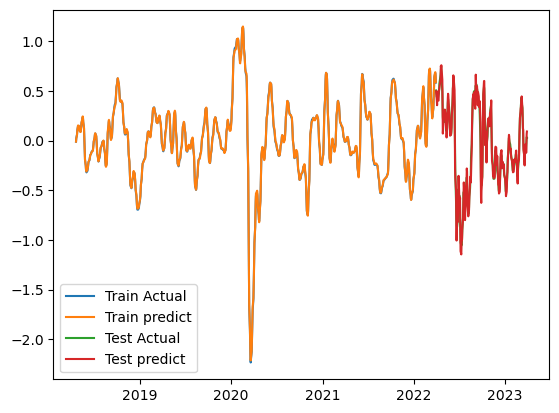

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 4ms/step
Train_MAE: 0.007250330154784023
Test_MAE: 0.010763164516538382


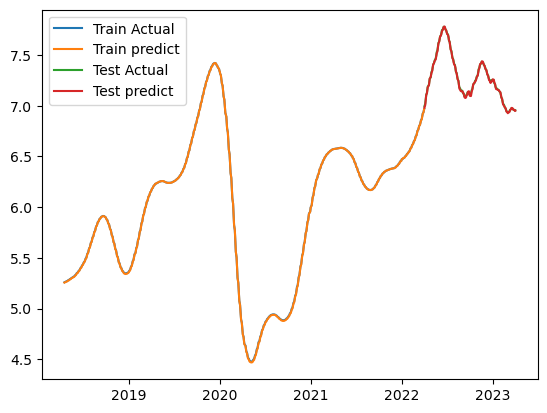

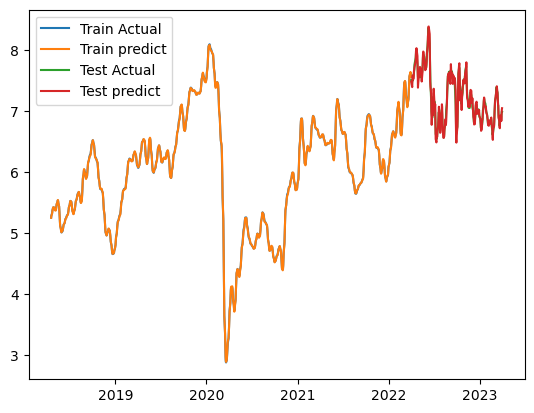

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.019827469997107983
Test_MAE: 0.05338534414768219


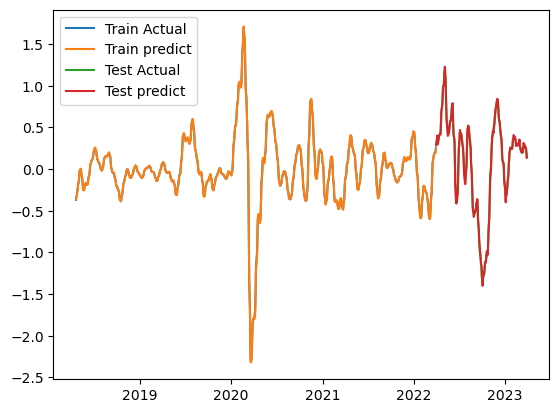

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 4ms/step
Train_MAE: 0.00425543338060379
Test_MAE: 0.004287737235426903


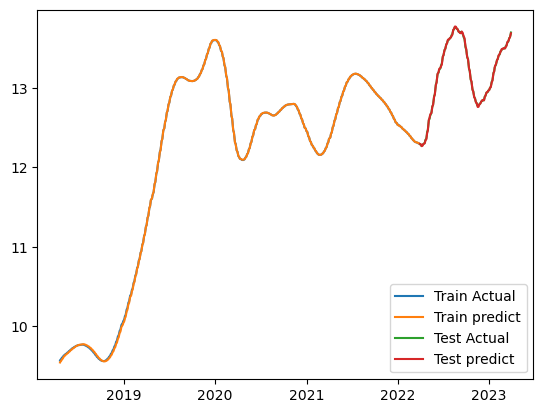

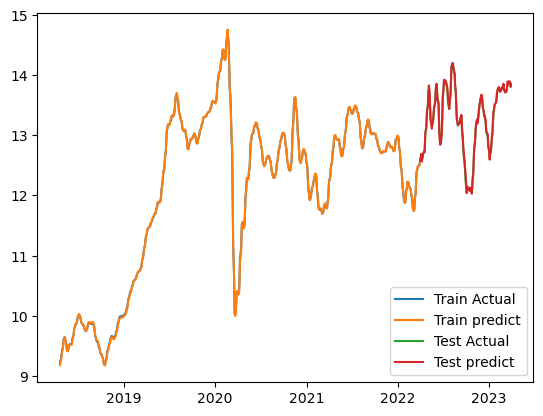

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 4ms/step
Train_MAE: 0.024661372043192388
Test_MAE: 0.13293008208274842


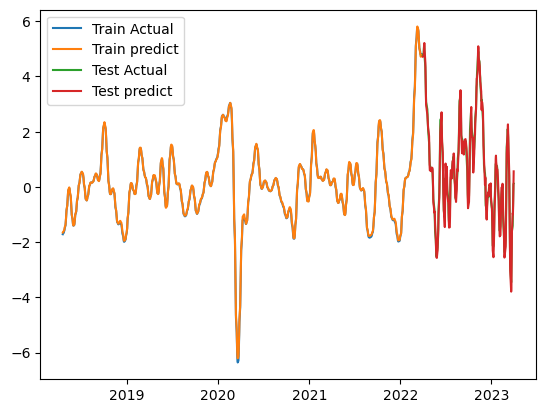

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.003396017197519541
Test_MAE: 0.011668825056403875


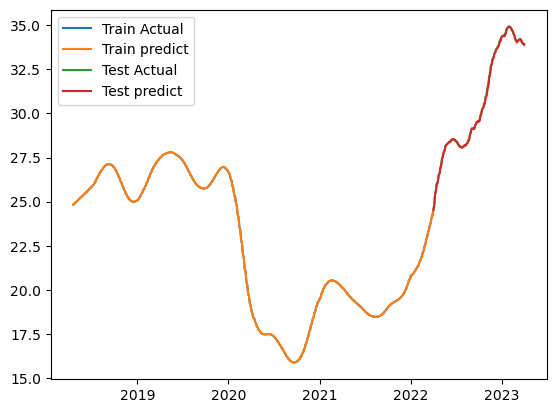

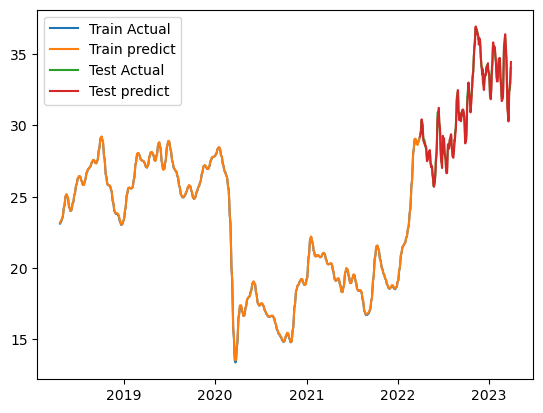

In [ ]:
obtain_all(2, show = True)